In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import multiprocessing as mp
from IPython import display


sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
grabo_root = Path("../data/grabo_w2v/blocks")
patience_root = Path("../../../patience/sti1/data/blocks")

In [4]:
def load_classification_report(path):
    path = Path(path)
    speaker = path.parents[2].name
    block_id, exp_id = path.parents[1].name.split("_")
    nblocks = int(block_id.replace("blocks", ""))
    exp_id = int(exp_id.replace("exp", ""))
    columns = ['precision', 'recall', 'f1-score', 'support']
    with open(path) as f:
        scores = list(filter(bool, map(str.strip, f.readlines()[1:-4])))
        
    index, values = zip(*map(lambda l: l.split(maxsplit=1), scores))
    return (pd.DataFrame(map(str.split, values), index=index, columns=columns)
            .apply(pd.to_numeric)
            .reset_index()
            .rename(columns={"index": "class"})
            .assign(speaker=speaker, nblocks=nblocks, exp_id=exp_id))
    

def load_results(root, exp_name="text_average", model_id="linear_1_first"):
    suffix = f"_{model_id}" if model_id is not None else ""
    pattern = f"**/**/{exp_name}/test_scores{suffix}.txt"
    with mp.Pool(12) as pool:
        reports = pd.concat(
            pool.map(load_classification_report, root.glob(pattern)),
            axis=0
        )
    return reports.set_index(["speaker", "nblocks", "exp_id", "class"])



# scores = load_classification_report("data/grabo_w2v/blocks/pp10/10blocks_exp0/classification_report_sti.txt")
# results = load_results(grabo_root, exp_name="text_average", model_id=None)

In [5]:
def plot_learning_curve(scores, metric="f1-score", speakers=None, agg=False, ax=None, label=None):
    if speakers is not None:
        if isinstance(speakers, str):
            speakers = [speakers]
        scores = scores[scores.index.get_level_values(0).isin(speakers)]

    agg_scores = (
        scores.groupby(level=["speaker", "nblocks", "exp_id"])
        .apply(lambda g: np.average(g[metric], weights=g["support"]))
    )
    
    avg_scores = (
        agg_scores.groupby(level=["speaker", "nblocks"])
        .agg(["mean", 'std'])
        .reset_index()
    )
        
    speakers = sorted(avg_scores["speaker"].unique())
    ax = ax or plt.subplot()
    
    if agg:
        data = avg_scores.groupby("nblocks").mean().reset_index()
        ax.errorbar(x=data["nblocks"], y=data["mean"], yerr=data["std"], capsize=3, label=label)
        return ax
        
    for speaker in speakers:
        data = avg_scores.loc[avg_scores["speaker"] == speaker]
        ax.errorbar(x=data["nblocks"], y=data["mean"], yerr=data["std"], capsize=3, label=speaker)
        
    if len(speakers) > 1:
        ax.legend(loc=4)
        
#     ax.set_ylim(0, 1.1)
#     ax.set_yscale('log')
    
    return ax

# plot_learning_curve(
#     load_results(grabo_root),
# #     speakers=["pp10", "pp11", "pp12", "pp2", "pp3"]
# );

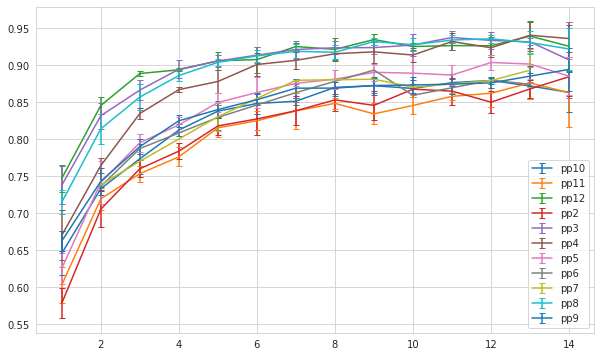

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(grabo_root, exp_name="vec_average", model_id=None), ax=ax)

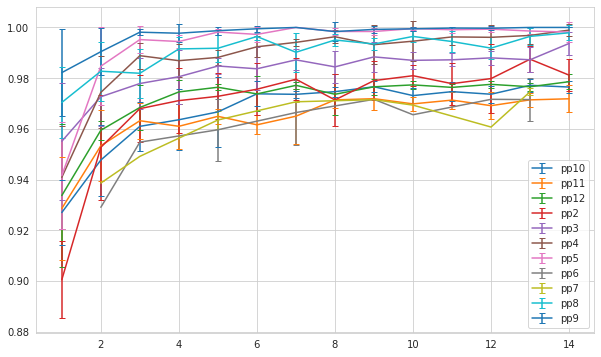

In [265]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(grabo_root, exp_name="text_average", model_id=None))

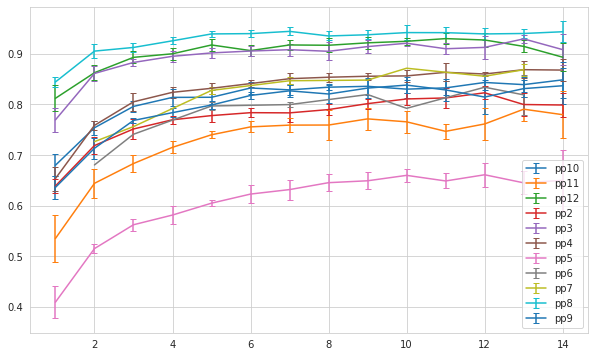

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(grabo_root, exp_name="asr_average", model_id=None))

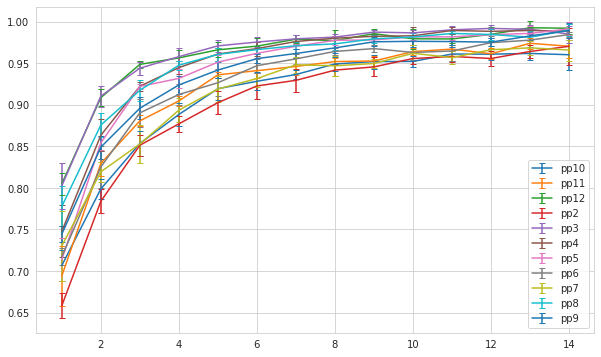

In [278]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(grabo_root, exp_name="features_combine_average", model_id="linear_1_mean"), ax=ax)

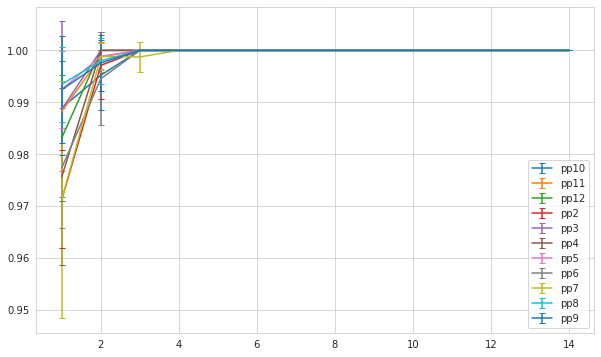

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(grabo_root, exp_name="text_average_svm", model_id=None), ax=ax)

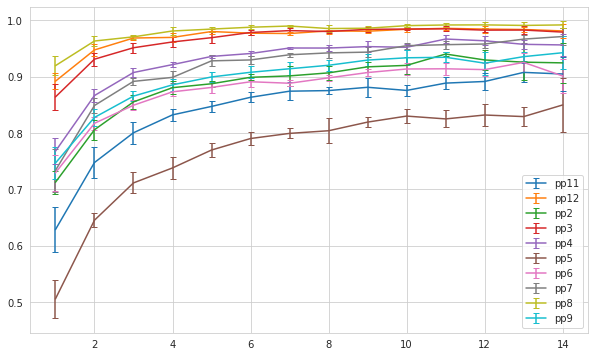

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(grabo_root, exp_name="asr_average_svm", model_id=None), ax=ax)

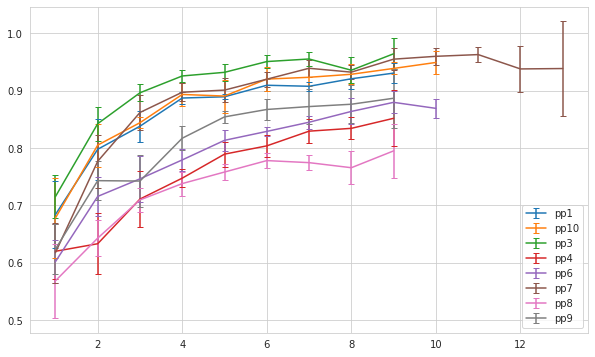

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(patience_root, exp_name="text_average", model_id=None))

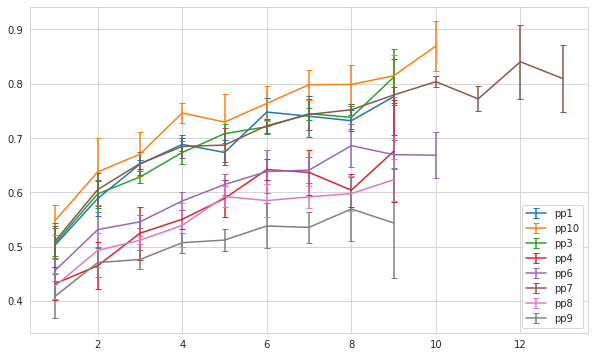

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(patience_root, exp_name="asr_average", model_id=None))

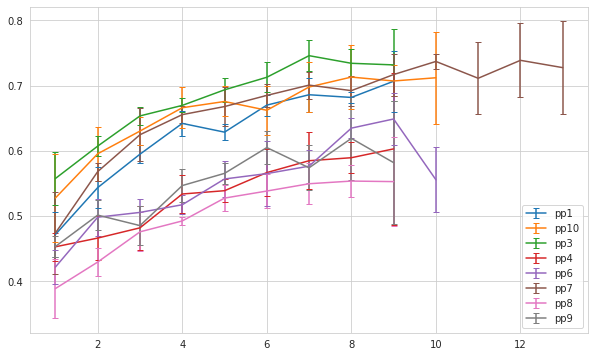

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(patience_root, exp_name="vec_average", model_id=None))

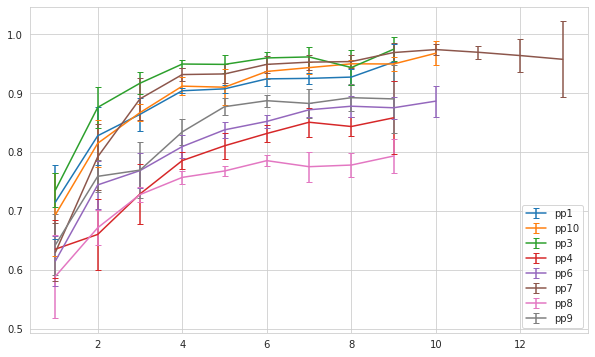

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(patience_root, exp_name="text_average_svm", model_id=None))

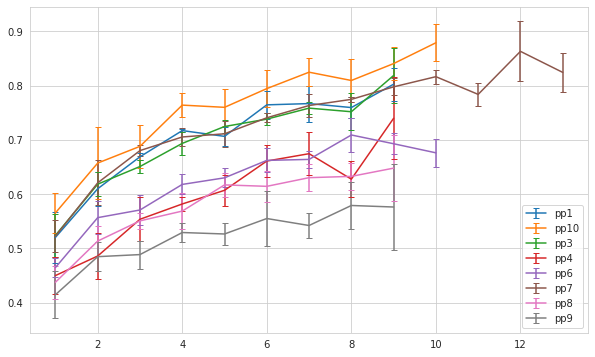

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(patience_root, exp_name="asr_average_svm", model_id=None))

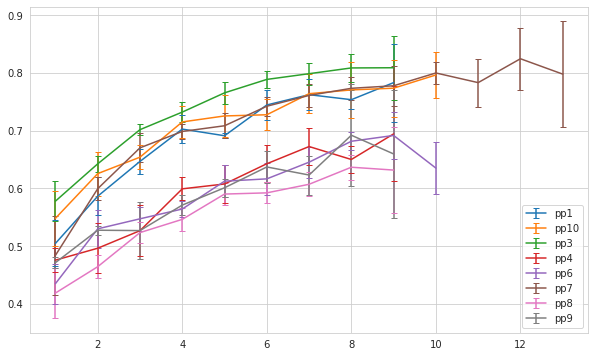

In [279]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(patience_root, exp_name="features_combine_average", model_id="linear_1_mean"), ax=ax)

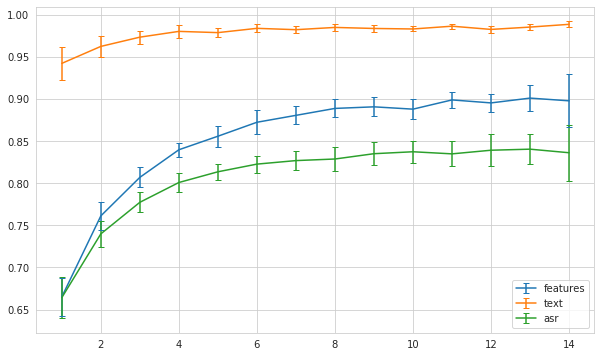

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(grabo_root, "vec_average", None), agg=True, ax=ax, label="features")
plot_learning_curve(load_results(grabo_root, "text_average", None), agg=True, ax=ax, label="text")
plot_learning_curve(load_results(grabo_root, "asr_average", None), agg=True, ax=ax, label="asr")
ax.legend();

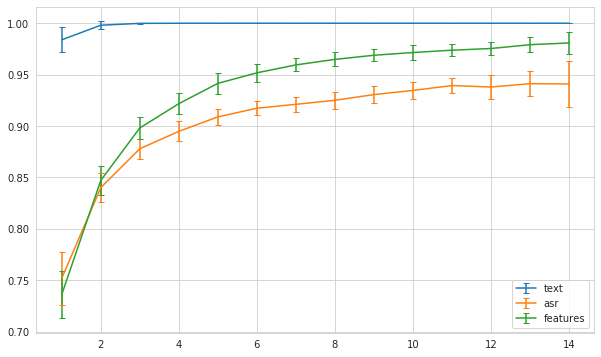

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(grabo_root, "text_average_svm", None), agg=True, ax=ax, label="text")
plot_learning_curve(load_results(grabo_root, "asr_average_svm", None), agg=True, ax=ax, label="asr")
plot_learning_curve(load_results(grabo_root, exp_name="features_combine_average", model_id="linear_1_mean"), agg=True, ax=ax, label="features")
ax.legend();

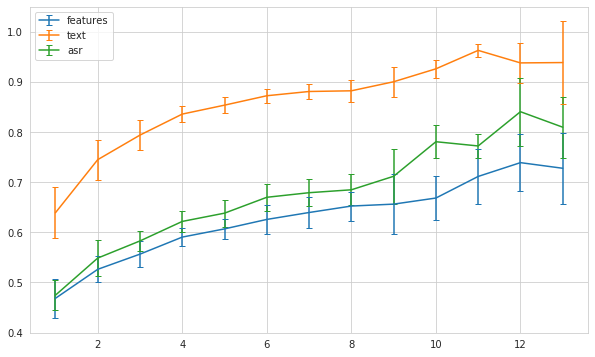

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(patience_root, "vec_average", None), agg=True, ax=ax, label="features")
plot_learning_curve(load_results(patience_root, "text_average", None), agg=True, ax=ax, label="text")
plot_learning_curve(load_results(patience_root, "asr_average", None), agg=True, ax=ax, label="asr")
ax.legend()

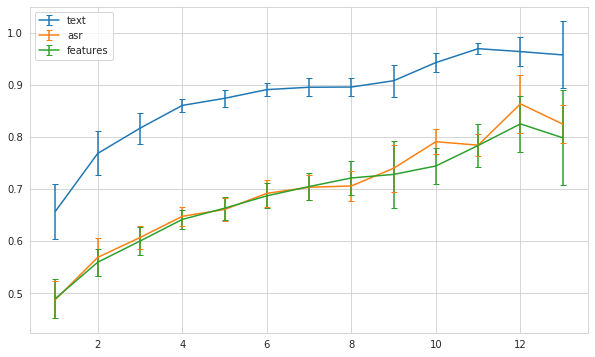

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot_learning_curve(load_results(patience_root, "text_average_svm", None), agg=True, ax=ax, label="text")
plot_learning_curve(load_results(patience_root, "asr_average_svm", None), agg=True, ax=ax, label="asr")
plot_learning_curve(load_results(patience_root, exp_name="features_combine_average", model_id="linear_1_mean"), agg=True, ax=ax, label="features")
ax.legend()

In [26]:
# results = load_results(patience_root, "vec_average", None)
(results.groupby(level=[0,1,2])
 .apply(lambda g: np.average(g["f1-score"], weights=g["support"])).unstack(level=0)
#  .mean(level=[0,1])
#  .sort_index()
#  .unstack(level=0).plot()
)

speaker              pp1      pp10       pp3       pp4       pp6       pp7  \
nblocks exp_id                                                               
1       0       0.503355  0.550569  0.537497  0.453706  0.394121  0.437301   
        1       0.455364  0.559534  0.595163  0.450097  0.400559  0.528783   
        2       0.419213  0.421248  0.555425  0.432219  0.456594  0.540917   
        3       0.487484  0.598587  0.502482  0.488466  0.439028  0.391884   
        4       0.492372  0.508067  0.596878  0.438634  0.417504  0.470611   
...                  ...       ...       ...       ...       ...       ...   
13      0            NaN       NaN       NaN       NaN       NaN  0.711111   
        1            NaN       NaN       NaN       NaN       NaN  0.812708   
        2            NaN       NaN       NaN       NaN       NaN  0.637586   
        3            NaN       NaN       NaN       NaN       NaN  0.692308   
        4            NaN       NaN       NaN       NaN       NaN  0.784314   

speaker              pp8       pp9  
nblocks exp_id                      
1       0       0.360885  0.464044  
        1       0.335685  0.425463  
        2       0.379296  0.458672  
        3       0.418053  0.464703  
        4       0.448905  0.452855  
...                  ...       ...  
13      0            NaN       NaN  
        1            NaN       NaN  
        2            NaN       NaN  
        3            NaN       NaN  
        4            NaN       NaN  

[65 rows x 8 columns]

In [33]:
results.xs(("pp1", 1, 0)).mean()

/users/spraak/qmeeus/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


precision     0.291290
recall        0.140968
f1-score      0.164839
support      19.903226
dtype: float64

In [29]:
!cat ../../../patience/sti1/data/blocks/pp1/1blocks_exp0/vec_average/test_scores.txt

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       136
           1       1.00      0.92      0.96       108
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         8
          14       0.14      0.10      0.12        20
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.25    

In [17]:
(pd.read_csv("../exp/figures/learning_curve_text/feats_average/scores.csv", index_col=0, header=[0,1,2])
 .xs(("test", "mean"), axis=1)  #.T.plot()
)
# plt.gca().get_legend().remove()

/users/spraak/qmeeus/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


0.1     0.325      0.55     0.775       1.0
action_approach     0.488008  0.821147  0.897826  0.897826  0.897826
action_grab              NaN  0.554627  0.944444  0.944444  0.944444
action_lift         0.533392  0.624614  0.794529  0.828962  0.828962
action_move_abs     0.456001  0.902158  0.895027  0.918023  0.918023
action_move_rel     0.442041  0.924118  0.928788  0.928788  0.928788
action_pointer           NaN  0.592403  0.592403  0.727886  0.727886
action_turn_abs     0.515621  0.760397  0.804753  0.946732  0.969113
action_turn_rel     0.534724  0.913104  0.865177  0.910563  0.925676
throttle_fast       0.431666  0.882599  0.904770  0.914246  0.914246
throttle_slow       0.433708  0.849596  0.899672  0.911687  0.920325
distance_alot       0.500352  0.840450  0.861849  0.920774  0.905736
distance_little     0.476604  0.860887  0.895556  0.895556  0.895556
distance_normal     0.520541  0.757287  0.886140  0.924351  0.955238
direction_backward  0.490721  0.751331  0.831952  0.860427  0.861797
direction_forward   0.491790  0.768781  0.884222  0.899398  0.889012
angle_east               NaN  0.700736  0.801610  0.830523  0.857848
angle_north         0.489106  0.806715  0.761220  0.795652  0.898925
angle_south         0.474231  0.642075  0.819112  0.878433  0.921633
angle_west          0.466622  0.756148  0.830937  0.893471  0.908906
pos_x_centerx       0.574791  0.684044  0.792182  0.928788  0.928788
pos_x_left          0.534591  0.676666  0.874432  0.874432  0.895556
pos_x_right         0.534591  0.815932  0.884407  0.947778  0.947778
pos_y_centery       0.574791  0.684044  0.792182  0.928788  0.928788
pos_y_down          0.534591  0.815932  0.884407  0.947778  0.947778
pos_y_up            0.534591  0.676666  0.874432  0.874432  0.895556
position_down       0.494624  0.696774  0.595699  0.595699  0.595699
position_up              NaN  0.494624  0.696774  0.797849  0.797849
state_off                NaN  0.595699  0.493525  0.493525  0.493525
state_on                 NaN  0.595699  0.594600  0.864492  0.763417
grabber_close            NaN  0.494624  0.594600  0.594600  0.594600
grabber_open             NaN  0.491328  0.762319  0.762319  0.843369

In [40]:
(pd.read_csv("../exp/figures/learning_curve_text_patience/feats_average/scores.csv", index_col=0, header=[0,1,2])
 .xs(("test", "mean"), axis=1)
)

0.1     0.325      0.55     0.775       1.0
0   0.922895  0.939461  0.992443  0.992443  0.992443
1   0.922895  0.939461  0.992443  0.992443  0.992443
2   0.485439  0.515221  0.547789  0.587456  0.614332
3   0.521288  0.583169  0.637654  0.617278  0.627789
4        NaN  0.543833  0.583826  0.591176  0.584508
5   0.550405  0.575598  0.599940  0.635799  0.662125
6        NaN  0.523792  0.577998  0.549617  0.614169
7        NaN  0.545748  0.544518  0.544210  0.544210
8        NaN  0.497581  0.497581  0.496972  0.496666
9        NaN  0.497275  0.497277  0.496054  0.496664
10       NaN       NaN       NaN  0.698792  0.698792
11       NaN       NaN  0.598793  0.598184  0.598184
12       NaN       NaN       NaN       NaN  0.697557
13       NaN  0.611474  0.710698  0.774656  0.819965
14  0.774063  0.861404  0.888156  0.944787  0.938310
15  0.776989  0.877356  0.941944  0.949321  0.949742
16  0.778037  0.919138  0.935042  0.948135  0.942761
17  0.818879  0.911166  0.950607  0.957734  0.959812
18  0.909684  0.931245  0.948796  0.959575  0.952832
19  0.792037  0.903243  0.968506  0.973923  0.970280
20  0.740630  0.901808  0.957949  0.960016  0.960016
21  0.802166  0.892527  0.959262  0.956212  0.965176
22  0.901405  0.931556  0.944970  0.972298  0.975060
23  0.863919  0.913910  0.941240  0.962978  0.966315
24  0.833730  0.894630  0.935572  0.939647  0.967911
25  0.881470  0.908777  0.926504  0.947600  0.971308
26  0.896511  0.941907  0.950225  0.952324  0.964586
27  0.788439  0.829560  0.812359  0.833041  0.864808
28  0.679587  0.782621  0.858719  0.872437  0.863771
29  0.824039  0.830394  0.853419  0.858246  0.854626
30  0.789606  0.816757  0.857001  0.877501  0.864467

In [18]:
def get_nlines(fn):
    with open(fn) as f:
        return len(f.readlines())
    
directories, train_sizes, test_sizes = zip(*map(
    lambda d: (d, get_nlines(d / "train.ids"), get_nlines(d / "test.ids")), 
    Path("../data/grabo_w2v/blocks").glob("**/*blocks_exp*")))

In [33]:
index = pd.MultiIndex.from_tuples(
    map(lambda d: (d.parents[0].name, int(d.name.split("blocks")[0]), int(d.name.split("exp")[-1])), directories),
    names=["speaker", "nblocks", "exp_id"]
)

sizes = pd.DataFrame(index=index)
sizes["train_sz"] = train_sizes
sizes["test_sz"] = test_sizes
sizes["train_p"] = sizes["train_sz"] / (sizes["train_sz"] + sizes["test_sz"])
sizes[["train_p"]].groupby(level=[0,1]).mean().unstack(level=0).sort_index()

train_p                                                              \
speaker      pp10      pp11      pp12       pp2       pp3       pp4       pp5   
nblocks                                                                         
1        0.066667  0.066543  0.066667  0.066296  0.066667  0.066667  0.066667   
2        0.133333  0.133457  0.133333  0.133333  0.133333  0.133333  0.133333   
3        0.200000  0.200000  0.200000  0.200741  0.200000  0.200000  0.200000   
4        0.266667  0.266913  0.266667  0.267407  0.266667  0.266667  0.266667   
5        0.333333  0.333826  0.333333  0.332963  0.333333  0.333333  0.333333   
6        0.400000  0.399630  0.400000  0.400370  0.400000  0.400000  0.400000   
7        0.466667  0.466913  0.466667  0.467037  0.466667  0.466667  0.466667   
8        0.533333  0.533087  0.533333  0.533333  0.533333  0.533333  0.533333   
9        0.600000  0.599630  0.600000  0.600370  0.600000  0.600000  0.600000   
10       0.666667  0.666913  0.666667  0.665926  0.666667  0.666667  0.666667   
11       0.733333  0.733457  0.733333  0.733704  0.733333  0.733333  0.733333   
12       0.800000  0.800000  0.800000  0.800000  0.800000  0.800000  0.800000   
13       0.866667  0.866543  0.866667  0.866296  0.866667  0.866667  0.866667   
14       0.933333  0.932717  0.933333  0.932963  0.933333  0.933333  0.933333   

                                                 
speaker       pp6       pp7       pp8       pp9  
nblocks                                          
1        0.063327  0.073333  0.066667  0.066667  
2        0.126297  0.126667  0.133333  0.133333  
3        0.199284  0.189825  0.200000  0.200000  
4        0.261896  0.252982  0.266667  0.266667  
5        0.338462  0.336491  0.333333  0.333333  
6        0.397496  0.400351  0.400000  0.400000  
7        0.453667  0.483158  0.466667  0.466667  
8        0.524866  0.516842  0.533333  0.533333  
9        0.611091  0.608772  0.600000  0.600000  
10       0.653309  0.672632  0.666667  0.666667  
11       0.725939  0.736491  0.733333  0.733333  
12       0.789267  0.810175  0.800000  0.800000  
13       0.874061  0.873333  0.866667  0.866667  
14       0.935599  0.927018  0.933333  0.933333

In [214]:
display.Audio("/users/spraak/qmeeus/data/grabo/speakers/pp6/spchdatadir/recording1/Voice_10.wav")

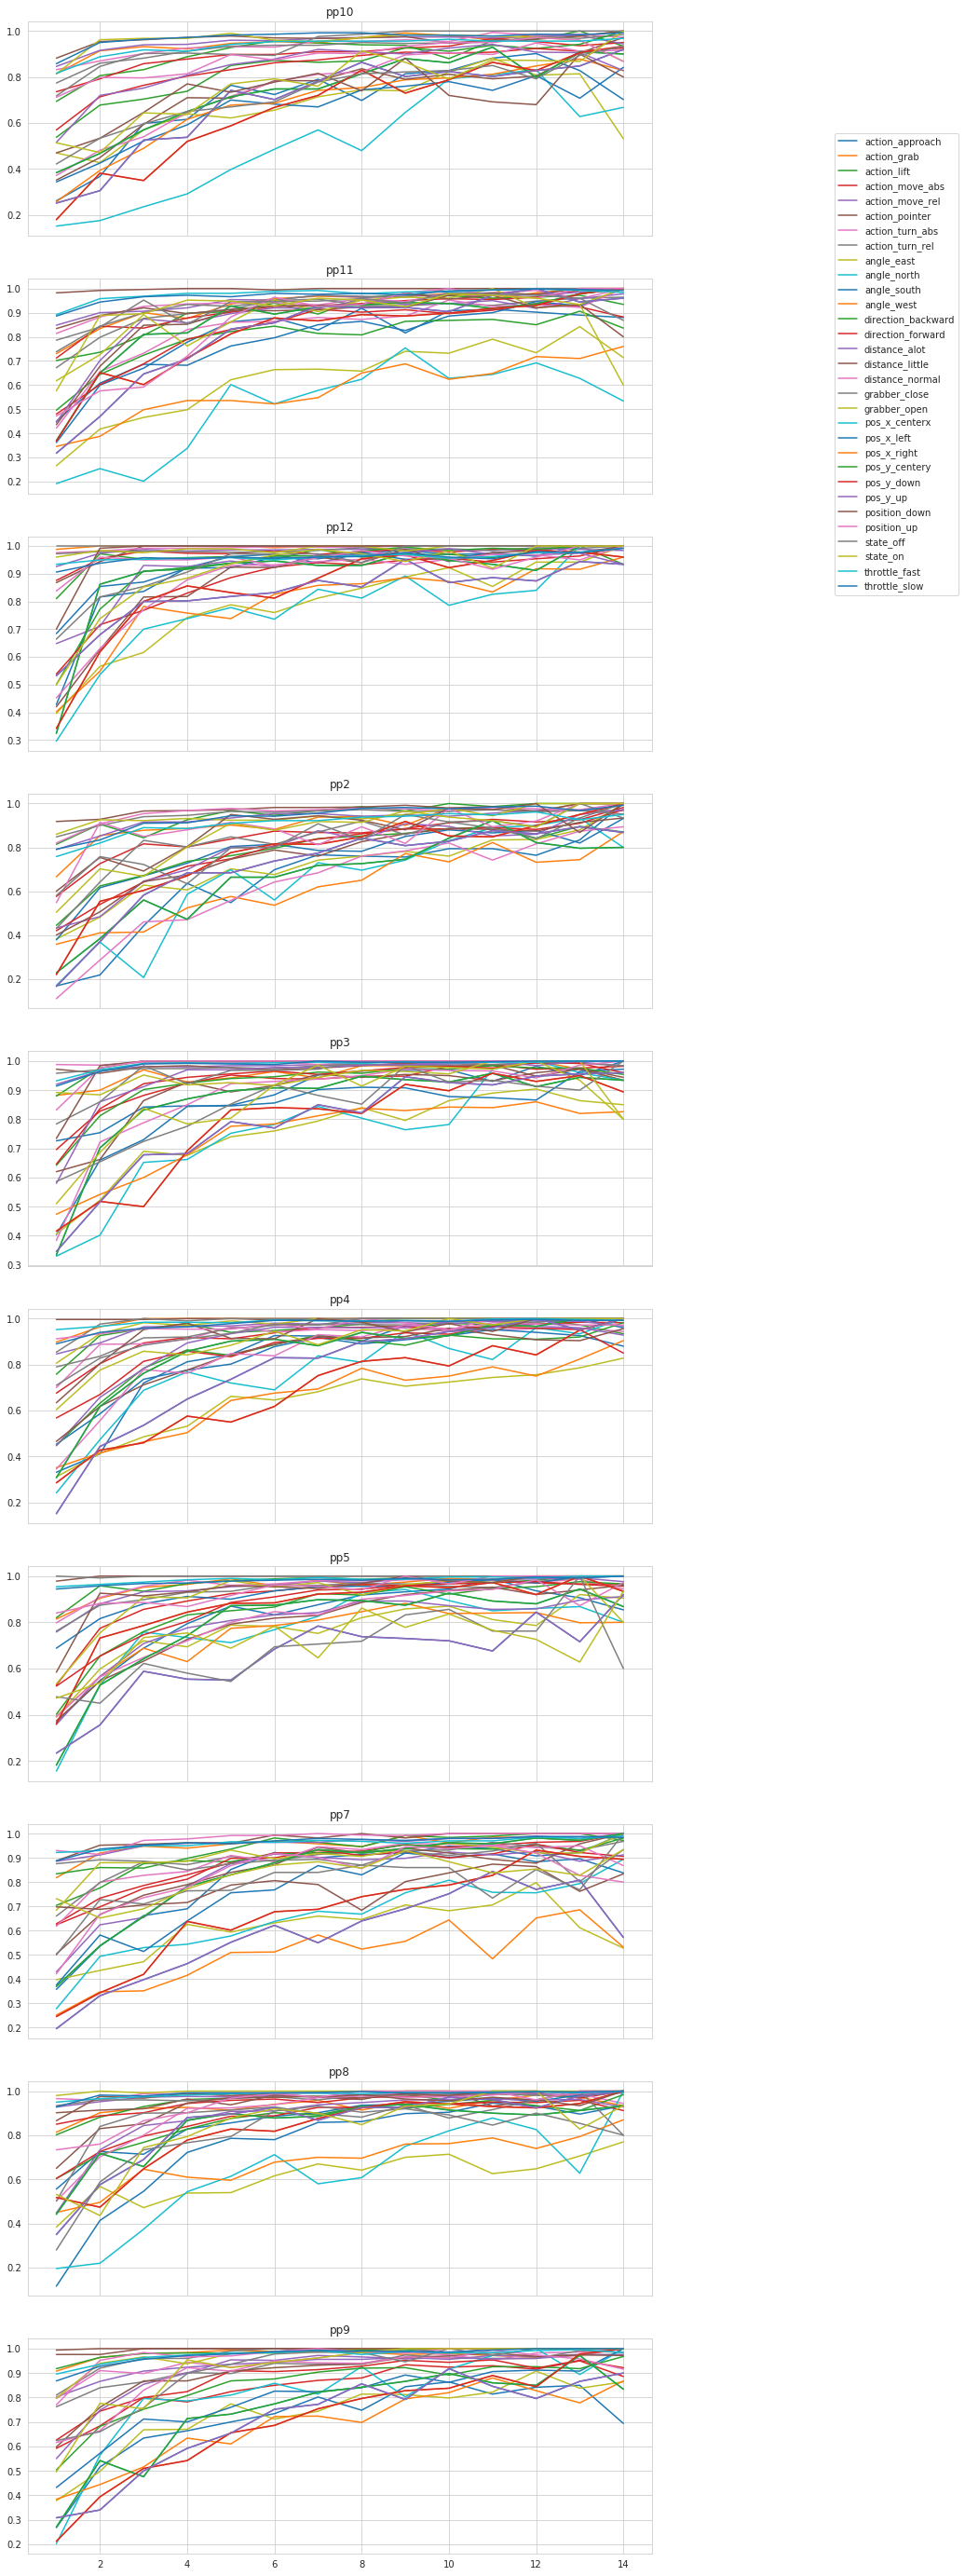

In [472]:
def plot_learning_curve_classes(results):

    speakers = sorted(results.index.levels[0])

    fig, axs = plt.subplots(len(speakers), 1, figsize=(12, 5 * len(speakers)), sharex=True)
    for i, (speaker, ax) in enumerate(zip(speakers, axs)):
        data = (
            results.xs(speaker, level=0)
            .groupby(level=["nblocks", "class"])
            .agg('mean')["f1-score"]
            .unstack(level=-1)
        )

        data.plot(ax=ax)
        legend = ax.get_legend()
        if i != 0:
            legend.remove()
        else:
            ax.legend(ncol=1, bbox_to_anchor=(1., 0., .5, .5))

        ax.set_xlabel("")
        ax.set_title(speaker)
        
plot_learning_curve_classes(load_results(grabo_root))

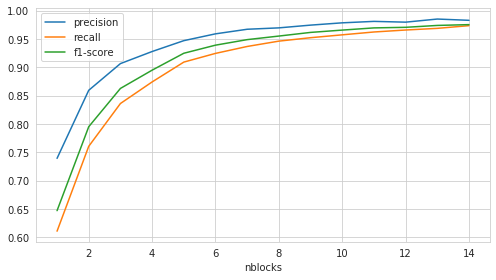

In [606]:
model_id = "linear_1_mean"
results = load_results(grabo_root, model_id)
# results = load_results(patience_root)

fig, ax = plt.subplots(1, 1, figsize=(7,4))

(
    results[["precision", "recall", "f1-score"]]
    .groupby(level=["nblocks"])
    .mean().plot(ax=ax)
)

plt.tight_layout()
plt.savefig(f"exp/figures/grabo_{model_id}_score_x0.png")

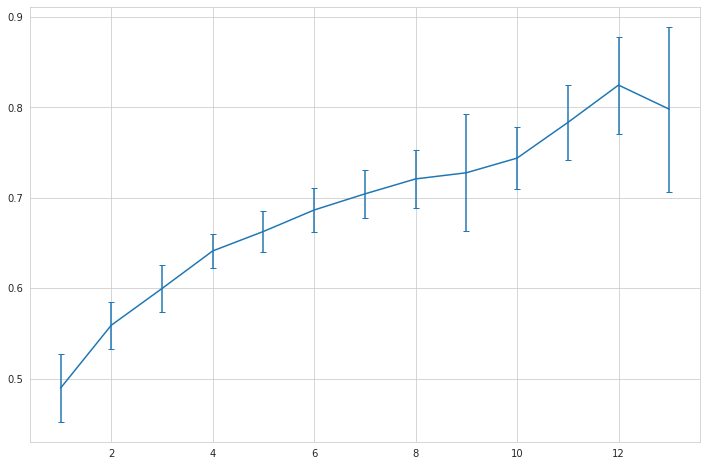

In [274]:


# fig, ax = plt.subplots(1, 1, figsize=(7,4))

# (
#     results[["precision", "recall", "f1-score"]]
#     .groupby(level=[0,1,2])
#     .mean().plot(ax=ax)
# )

# plt.tight_layout()
# # plt.savefig(f"exp/figures/grabo_{model_id}_score_x0.png")
# results

In [677]:
results.groupby('class').mean().shape

(31, 4)

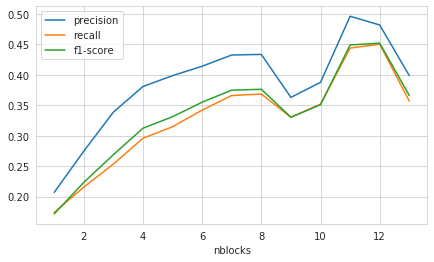

In [673]:
model_id = "linear_1_mean"
results = load_results(patience_root, model_id)
# results = load_results(patience_root)

fig, ax = plt.subplots(1, 1, figsize=(7,4))

(
    results[["precision", "recall", "f1-score"]]
    .groupby(level=["speaker", "nblocks"])
    .mean().groupby("nblocks").mean().plot(ax=ax)
)

# plt.tight_layout()
# plt.savefig(f"exp/figures/patience_{model_id}_score_x0.png")

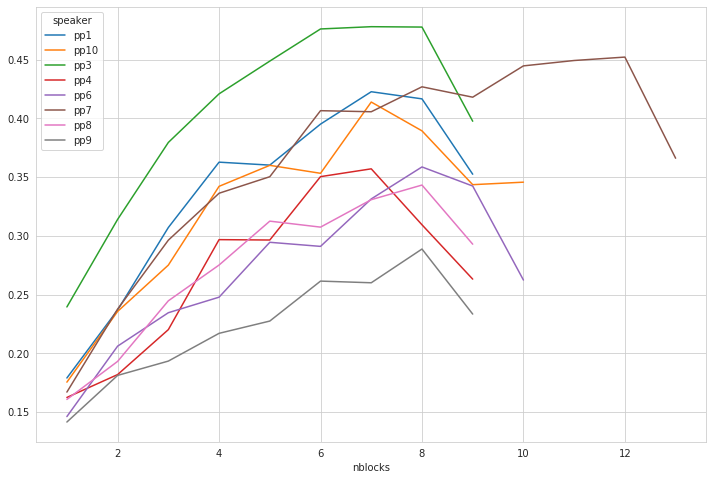

In [612]:
(load_results(patience_root, "linear_1_mean")["f1-score"]
 .groupby(level=["speaker", "nblocks"])
 .mean()
 .unstack(0)
 .plot()
#  .set_ylim(0, 1)
#  .set_yscale('log')
);


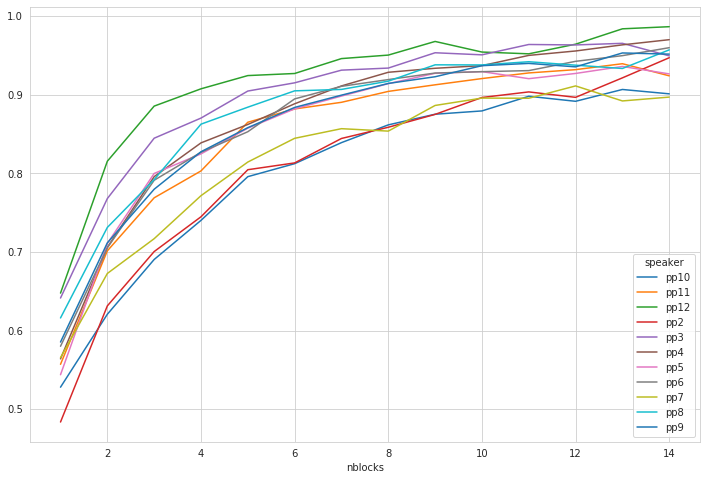

In [613]:
(load_results(grabo_root, "linear_1_mean")["f1-score"]
 .groupby(level=["speaker", "nblocks"])
 .mean()
 .unstack(0)
 .plot()
#  .set_ylim(0, 1)
#  .set_yscale('log')
);



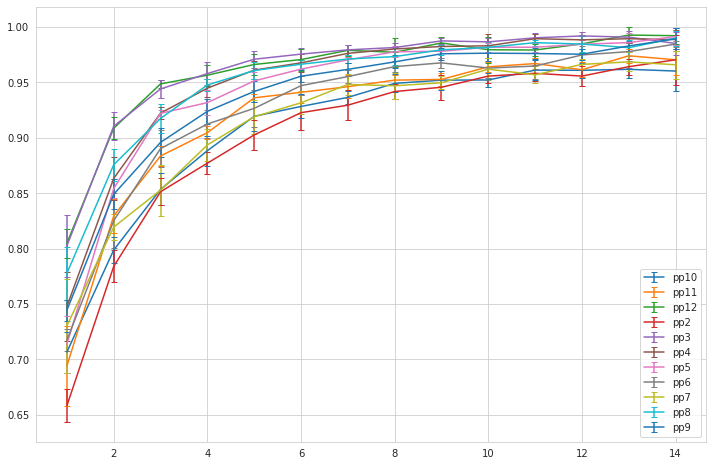

In [615]:
plot_learning_curve(
    load_results(grabo_root, model_id="linear_1_mean"),
#     speakers=["pp10", "pp11", "pp12", "pp2", "pp3"]
);

plt.savefig("exp/figures/grabo_linear_1_mean_speaker.png")

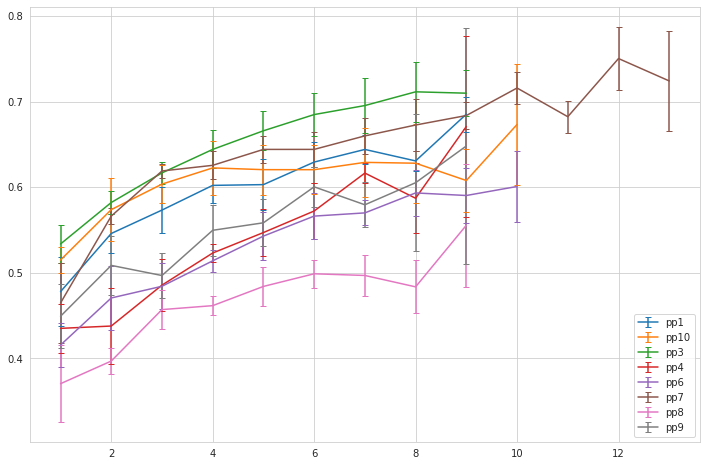

In [706]:
plot_learning_curve(
    load_results(patience_root, model_id="linear_1_mean"),
#     speakers=["pp10", "pp11", "pp12", "pp2", "pp3"]
);

# plt.savefig("exp/figures/grabo_linear_1_first_speaker.png")

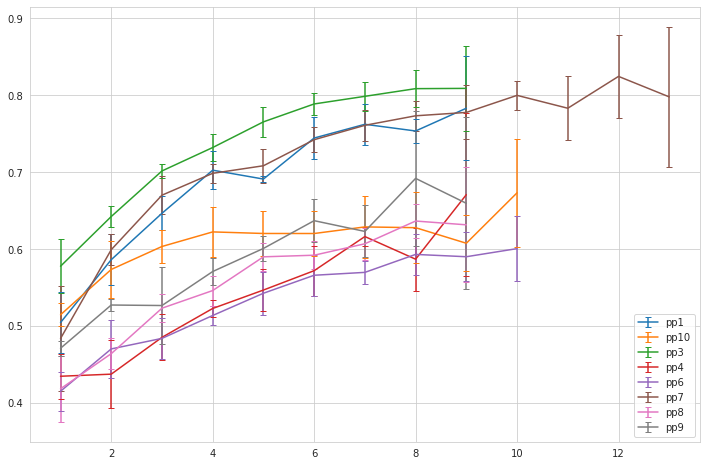

In [608]:
plot_learning_curve(
    load_results(patience_root, model_id="linear_1_mean"),
#     speakers=["pp10", "pp11", "pp12", "pp2", "pp3"]
);

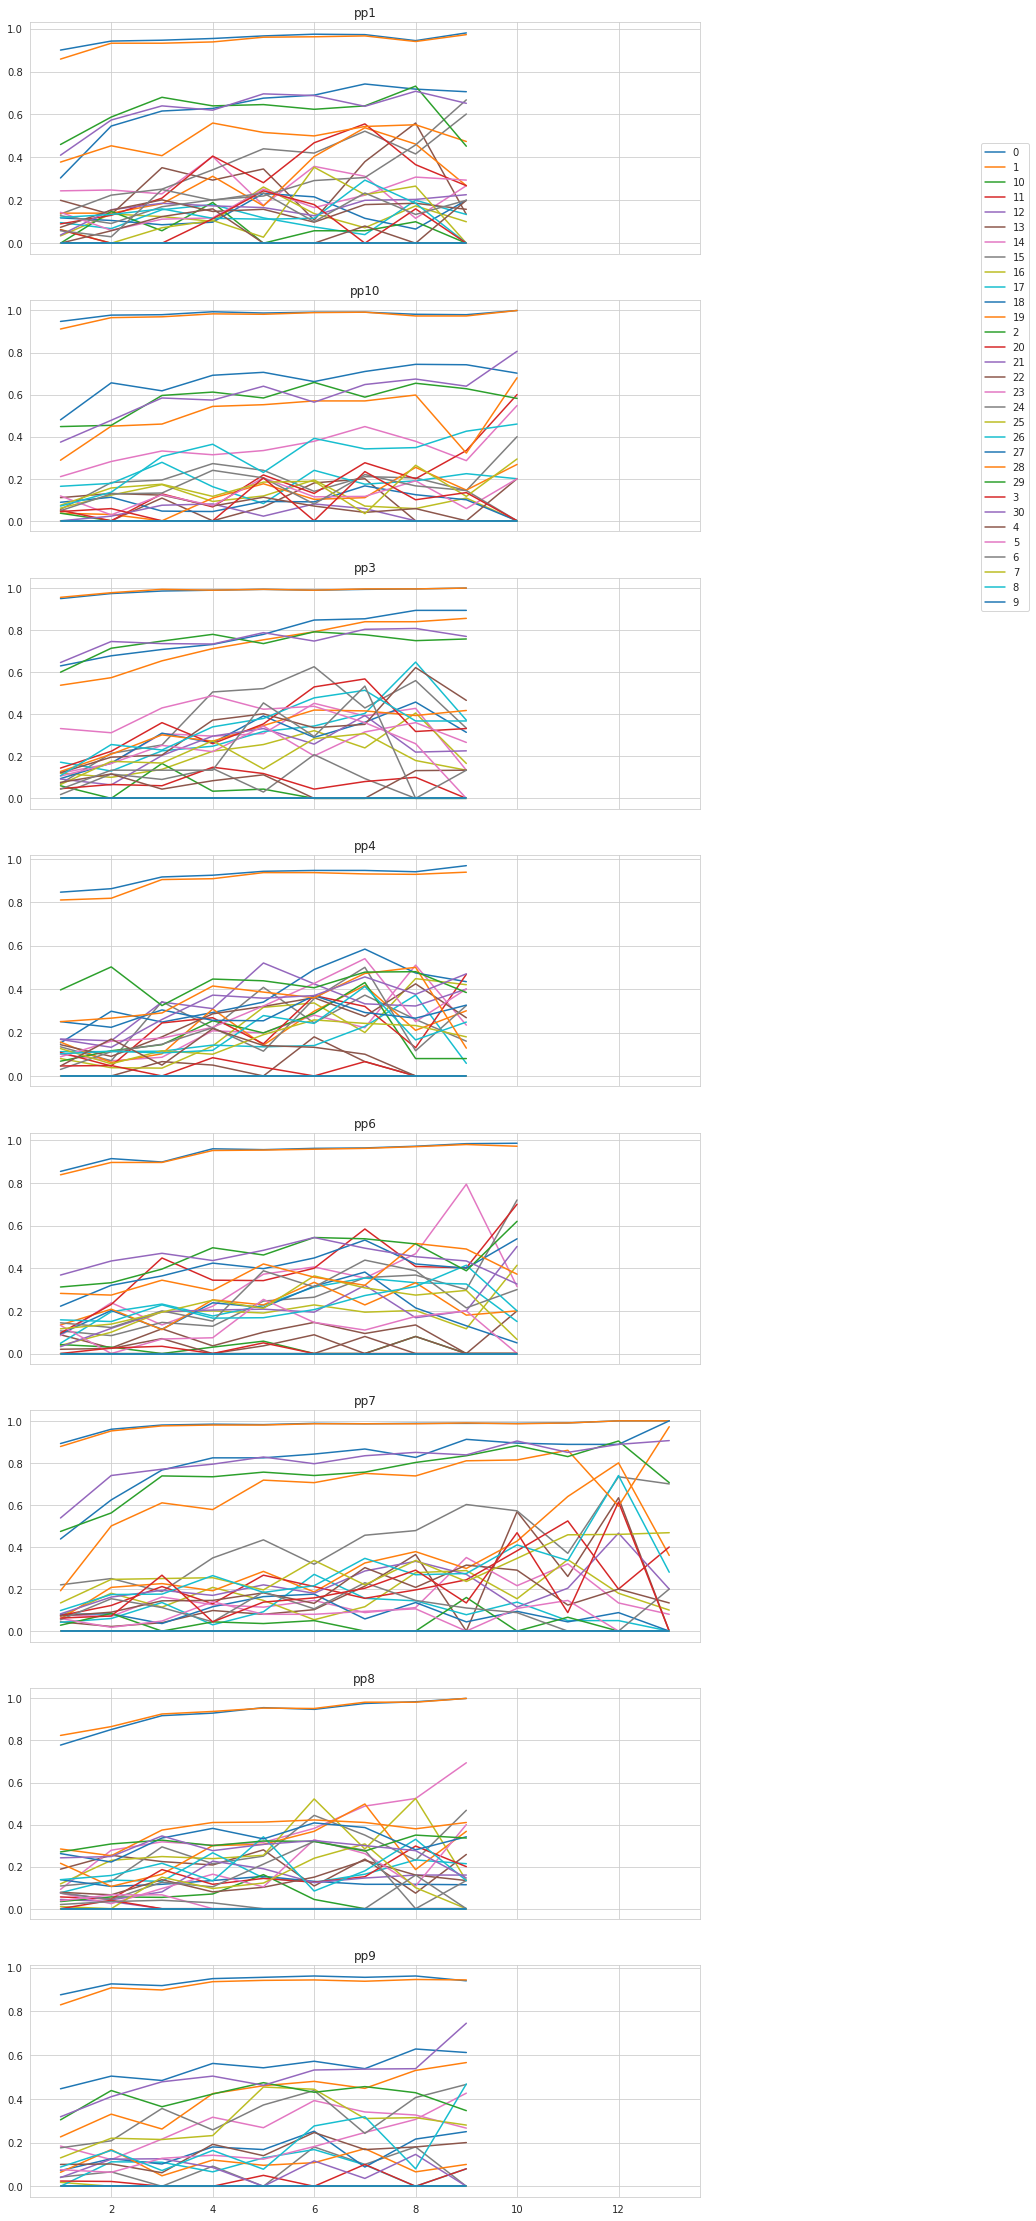

In [553]:
plot_learning_curve_classes(load_results(patience_root))

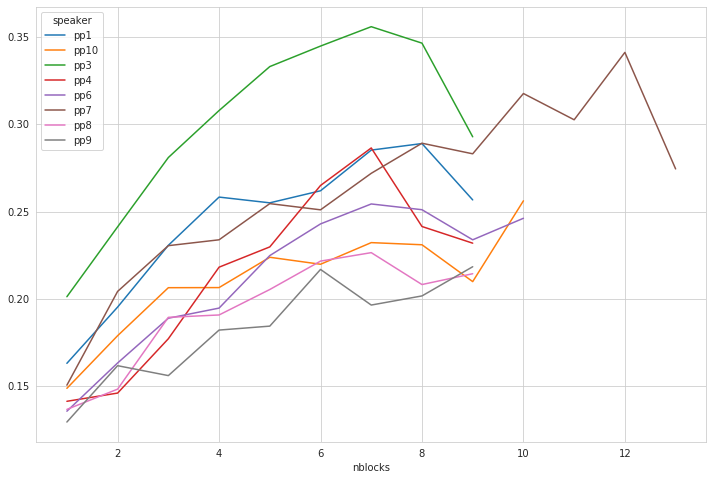

In [555]:
(load_results(patience_root)
 .groupby(level=["speaker", "nblocks"])
 .mean()["f1-score"]
 .unstack(0)
 .plot()
#  .set_yscale('log')
)

In [402]:
exp_dir = Path(patience_root, "pp7/5blocks_exp0")
predictions = np.load(exp_dir.joinpath("test_results_sti.npy"))
target = pd.read_csv(patience_root.joinpath("../encoded_target.csv"), index_col='uttid').astype(int)
with open(exp_dir.joinpath("test.ids")) as f:
    test_ids = list(map(str.strip, f.readlines()))
    test_target = target.loc[test_ids]

In [282]:
import h5py

with h5py.File(patience_root.joinpath("../features.h5"), 'r') as h5f:
    feats = [h5f[key][()] for key in test_ids]
    
feats = np.array([feat[0] for feat in feats])

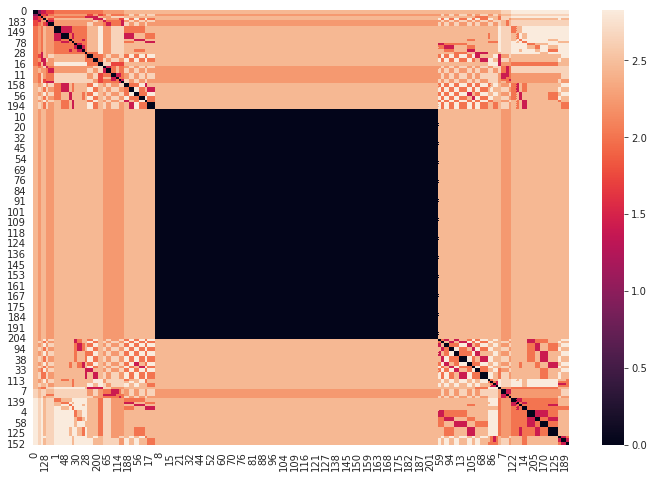

In [319]:
from scipy.spatial import distance_matrix

target_distances = pd.DataFrame(distance_matrix(test_target, test_target))
indices = target_distances.sort_values(list(range(len(test_target)))).index
sns.heatmap(target_distances.loc[indices, indices])

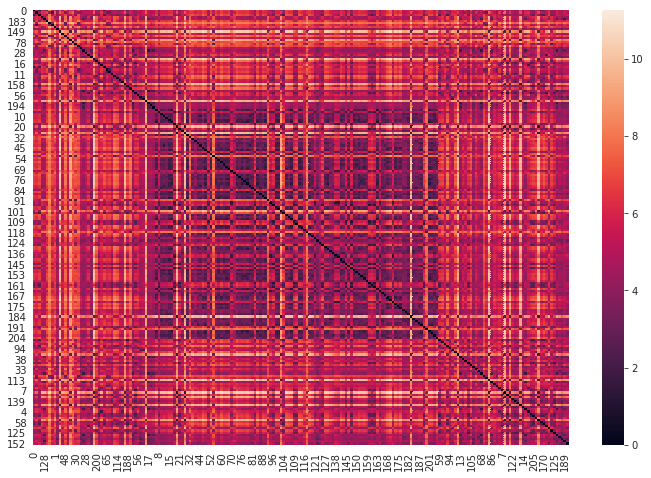

In [324]:
sns.heatmap(pd.DataFrame(distance_matrix(feats, feats)).reindex_like(target_distances).loc[indices, indices])

In [578]:
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support

target = pd.read_csv(grabo_root.joinpath("../encoded_target.csv"), index_col='uttid').astype(int)

with open(exp_dir.joinpath("train.ids")) as f:
    train_ids = list(map(str.strip, f.readlines()))

with open(exp_dir.joinpath("test.ids")) as f:
    test_ids = list(map(str.strip, f.readlines()))
    
y_train = target.loc[train_ids]
y_test = target.loc[test_ids]

with h5py.File(grabo_root.joinpath("../features.h5"), 'r') as h5f:
    X_train = np.array([h5f[key][()].mean(0) for key in train_ids])
    X_test = np.array([h5f[key][()].mean(0) for key in test_ids])
    
test_scores = []
for i, target_name in enumerate(y_train.columns):
    if y_train[target_name].nunique() < 2:
        print(f"Class {i}: NaN")
        test_scores += [[np.nan] * 3]
        continue
    clf = SVC(C=1000).fit(X_train, y_train.values[:, i])
    y_pred = clf.predict(X_test)
    *scores, _ = precision_recall_fscore_support(y_test.values[:, i], y_pred, average="macro", zero_division=0)
    print("Class {}: P={} R={} F1={}".format(i, *map("{:.4f}".format, scores)))
    test_scores += [scores]

print("\nTotal: P={} R={} F1={}".format(*map("{:.4f}".format, np.nanmean(test_scores, axis=0))))

Class 0: P=0.9951 R=0.9167 F1=0.9521
Class 1: P=1.0000 R=1.0000 F1=1.0000
Class 2: P=1.0000 R=1.0000 F1=1.0000
Class 3: P=1.0000 R=1.0000 F1=1.0000
Class 4: P=0.9932 R=0.9861 F1=0.9895
Class 5: P=1.0000 R=1.0000 F1=1.0000
Class 6: P=1.0000 R=1.0000 F1=1.0000
Class 7: P=0.9945 R=0.9722 F1=0.9830
Class 8: P=0.9722 R=0.9659 F1=0.9690
Class 9: P=0.9855 R=0.9756 F1=0.9801
Class 10: P=0.9948 R=0.9583 F1=0.9757
Class 11: P=0.9898 R=0.9167 F1=0.9494
Class 12: P=0.9531 R=0.9531 F1=0.9531
Class 13: P=1.0000 R=1.0000 F1=1.0000
Class 14: P=0.9891 R=0.9444 F1=0.9651
Class 15: P=0.9950 R=0.9444 F1=0.9681
Class 16: P=0.9953 R=0.8333 F1=0.8976
Class 17: P=0.9950 R=0.9444 F1=0.9681
Class 18: P=0.9950 R=0.9444 F1=0.9681
Class 19: P=1.0000 R=1.0000 F1=1.0000
Class 20: P=0.9951 R=0.9167 F1=0.9521
Class 21: P=1.0000 R=1.0000 F1=1.0000
Class 22: P=1.0000 R=1.0000 F1=1.0000
Class 23: P=1.0000 R=1.0000 F1=1.0000
Class 24: P=0.9951 R=0.9167 F1=0.9521
Class 25: P=0.9953 R=0.8333 F1=0.8976
Class 26: P=1.0000 R=1

In [331]:
label_columns = [
    "action", "throttle", "distance", "direction", "angle",
    "pos_x", "pos_y", "position", "state", "grabber"
]

labels = [
    'action_approach', 'action_grab', 'action_lift', 'action_move_abs',
    'action_move_rel', 'action_pointer', 'action_turn_abs', 'action_turn_rel',
    'throttle_fast', 'throttle_slow', 'distance_alot', 'distance_little',
    'distance_normal', 'direction_backward', 'direction_forward',
    'angle_east', 'angle_north', 'angle_south', 'angle_west',
    'pos_x_centerx', 'pos_x_left', 'pos_x_right',
    'pos_y_centery', 'pos_y_down', 'pos_y_up',
    'position_down', 'position_up', 'state_off', 'state_on',
    'grabber_close', 'grabber_open'
]


data = pd.read_csv(
    grabo_root.joinpath("../../grabo/target.csv"), 
    usecols=["uttid", *label_columns], 
    index_col="uttid"
)

targets = pd.DataFrame(np.zeros((len(data), len(labels))), index=data.index, columns=labels)
targets.update(pd.get_dummies(data[label_columns]))
targets = targets.astype(np.int64)

targets.to_csv("data/grabo_w2v/encoded_target.csv")

In [468]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report


def load_data(indices):
    with h5py.File("data/grabo_w2v/features.h5", "r") as h5f:
        features = np.array([h5f[key][()][0] for key in indices])
    
    targets = pd.read_csv("data/grabo_w2v/encoded_target.csv", index_col="uttid").loc[indices]
    return features, targets.values, targets.columns


def eval_svm(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred)
#     roc_auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision[0], recall[0], f1_score[0], 0


def train_classifier(exp_dir, clf):
    exp_dir = Path(exp_dir)
    (X_train, y_train, classes), (X_test, y_test, _) = (
        load_data(np.loadtxt(exp_dir.joinpath(f"{subset}.ids"), dtype='str'))
        for subset in ("train", "test")
    )

    N = y_train.shape[1]
    scores = np.empty((N,5))
    
    train_scores = []
    test_scores = []
    for i in range(y_train.shape[1]):
        if len(np.unique(y_train[:, i])) < 2:
            print(f"Class {i}: NaN")
            test_scores += [[np.nan] * 3]
            continue
        clf = clf.fit(X_train, y_train[:, i])

        y_pred = clf.predict(X_train)
        *scores, _ = precision_recall_fscore_support(y_train[:, i], y_pred, average="macro", zero_division=0)
        train_scores += [scores]

        
        y_pred = clf.predict(X_test)
        *scores, _ = precision_recall_fscore_support(y_test[:, i], y_pred, average="macro", zero_division=0)
        print("Class {}: P={} R={} F1={}".format(i, *map("{:.4f}".format, scores)))
        test_scores += [scores]

    print("\nTotal train: P={} R={} F1={}".format(*map("{:.4f}".format, np.nanmean(train_scores, axis=0))))
    print("Total test: P={} R={} F1={}".format(*map("{:.4f}".format, np.nanmean(test_scores, axis=0))))
    return clf

clf = SVC(C=10., kernel='linear', class_weight='balanced')
train_classifier("data/grabo_w2v/blocks/pp10/2blocks_exp0", clf)

Class 0: P=0.6799 R=0.6403 F1=0.6571
Class 1: P=0.8848 R=0.9536 F1=0.9159
Class 2: P=0.9411 R=0.8439 F1=0.8857
Class 3: P=0.8640 R=0.8333 F1=0.8475
Class 4: P=0.9325 R=0.9455 F1=0.9385
Class 5: P=0.9966 R=0.9423 F1=0.9677
Class 6: P=0.9604 R=0.8726 F1=0.9105
Class 7: P=0.9121 R=0.9205 F1=0.9162
Class 8: P=0.9382 R=0.9425 F1=0.9402
Class 9: P=0.9721 R=0.9721 F1=0.9721
Class 10: P=0.7963 R=0.8726 F1=0.8279
Class 11: P=0.6870 R=0.6310 F1=0.6515
Class 12: P=0.6956 R=0.6406 F1=0.6613
Class 13: P=0.7656 R=0.7628 F1=0.7642
Class 14: P=0.8476 R=0.8295 F1=0.8381
Class 15: P=0.7226 R=0.6748 F1=0.6949
Class 16: P=0.6391 R=0.6077 F1=0.6211
Class 17: P=0.7438 R=0.6305 F1=0.6653
Class 18: P=0.7486 R=0.7716 F1=0.7594
Class 19: P=0.6631 R=0.6210 F1=0.6382
Class 20: P=0.6277 R=0.5995 F1=0.6113
Class 21: P=0.8272 R=0.7059 F1=0.7507
Class 22: P=0.6631 R=0.6210 F1=0.6382
Class 23: P=0.8272 R=0.7059 F1=0.7507
Class 24: P=0.6277 R=0.5995 F1=0.6113
Class 25: P=0.9924 R=0.7308 F1=0.8120
Class 26: P=0.8907 R=0

SVC(C=10.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [567]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def train_classifier(exp_dir, clf):
    exp_dir = Path(exp_dir)
    (X_train, y_train, classes), (X_test, y_test, _) = (
        load_data(np.loadtxt(exp_dir.joinpath(f"{subset}.ids"), dtype='str'))
        for subset in ("train", "test")
    )

    N = y_train.shape[1]
#     scores = np.empty((N,5))
    
#     test_scores = []
#     for i in range(y_train.shape[1]):
#         if len(np.unique(y_train[:, i])) < 2:
#             print(f"Class {i}: NaN")
#             test_scores += [[np.nan] * 3]
#             continue
    clf = clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    print("Training scores:")
    print(classification_report(y_train, y_pred, zero_division=0.))

    print("Testing scores:")
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0.))

    *scores, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)
#     print("Class {}: P={} R={} F1={}".format(i, *map("{:.4f}".format, scores)))
#     test_scores += [scores]
#     print("\nTotal: P={} R={} F1={}".format(*map("{:.4f}".format, np.nanmean(test_scores, axis=0))))
    return clf

clf = SVC(C=10.0, kernel="linear")
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf = DecisionTreeClassifier(ccp_alpha=0.002)
train_classifier("data/grabo_w2v/blocks/pp10/1blocks_exp0", clf)

ValueError: bad input shape (36, 31)

In [419]:
exp_dir = Path("data/grabo_w2v/blocks/pp10/12blocks_exp0")
(X_train, y_train, classes), (X_test, y_test, _) = (
    load_data(np.loadtxt(exp_dir.joinpath(f"{subset}.ids"), dtype='str'))
    for subset in ("train", "test")
)

In [439]:
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

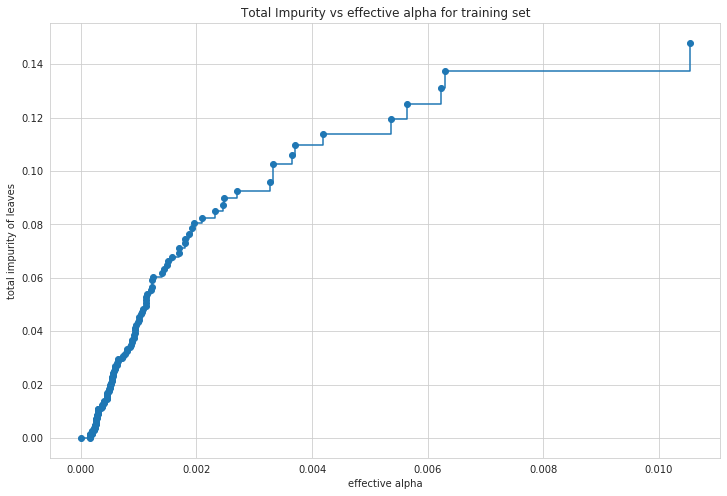

In [421]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [441]:
clfs = []
for i, ccp_alpha in enumerate(ccp_alphas):
    clf = RandomForestClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)    
#     print(
#         "Number of nodes in the tree {} is: {} with ccp_alpha: {}"
#         .format(i, clfs[-1].tree_.node_count, ccp_alphas[-1])
#     )

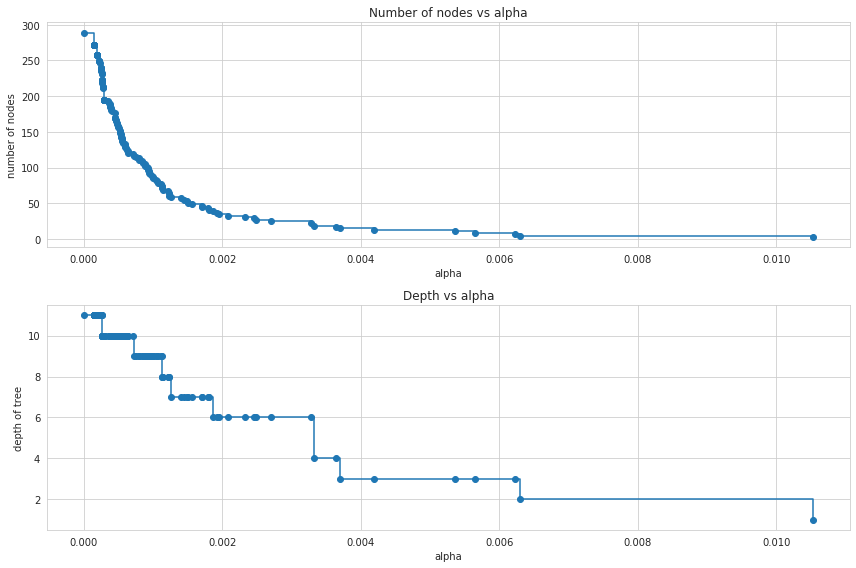

In [423]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

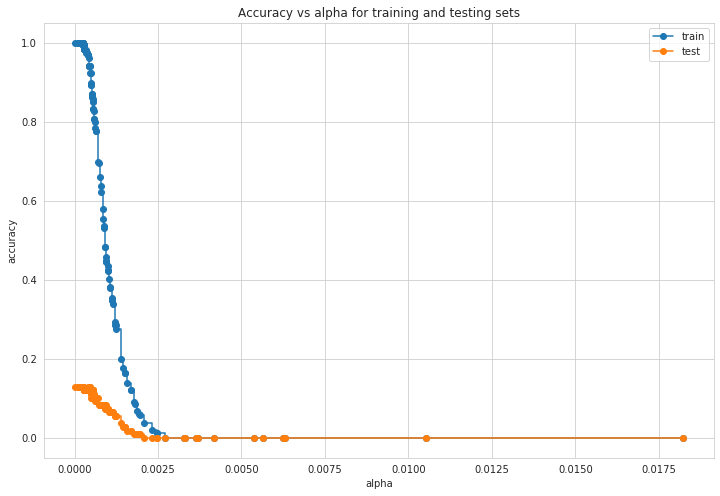

In [442]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend();

In [626]:
targets = pd.read_csv(Path(grabo_root, "../encoded_target.csv"), index_col="uttid")
with h5py.File(Path(grabo_root, "../features.h5"), "r") as h5f:
    keys = [key for key in targets.index if key in h5f]
    features = np.array([h5f[key][()][0] for key in keys])
    targets = targets.loc[keys].copy()
#     print([h5f[key][()].shape for key in keys])

In [524]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=8, n_init=20, max_iter=500, tol=0.0001).fit_predict(features)

print(list(zip(*np.unique(clusters, return_counts=True))))

[(0, 1189), (1, 594), (2, 475), (3, 600), (4, 468), (5, 423), (6, 304), (7, 1937)]


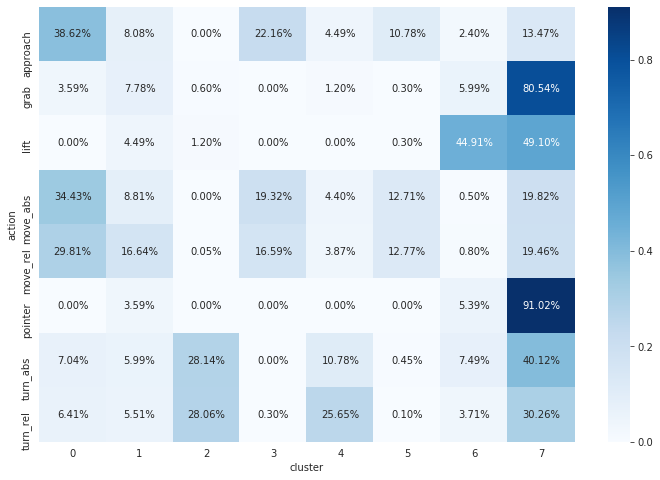

In [552]:
subcat = "action"

sns.heatmap(
    targets.loc[:, [col.startswith(subcat) for col in targets.columns]]
    .idxmax(axis=1)
    .str.replace(subcat + "_", "").rename(subcat).to_frame()
    .join(pd.Series(clusters, index=targets.index, name="cluster"))
    .assign(dummy=1)
    .pivot_table(index=subcat, columns="cluster", values="dummy", aggfunc="count")
    .fillna(0).astype(int).apply(lambda row: row/row.sum(), axis=1),
    annot=True, fmt=".2%", cmap="Blues"
)

In [634]:
# targets.columns = pd.MultiIndex.from_tuples(map(lambda s: s.split("_", maxsplit=1), targets.columns))
targets.xs("action", axis=1, level=0).apply(np.argmax, axis=1)

uttid
pp5_recording9_Voice_11      4
pp5_recording9_Voice_5       4
pp5_recording9_Voice_2       4
pp5_recording9_Voice_10      4
pp5_recording9_Voice_4       4
                            ..
pp12_recording13_Voice_14    3
pp12_recording13_Voice_6     3
pp12_recording13_Voice_9     3
pp12_recording13_Voice       3
pp12_recording13_Voice_3     3
Length: 5990, dtype: int64

S-curve, perplexity=5 in 44 sec
S-curve, perplexity=30 in 53 sec
S-curve, perplexity=50 in 57 sec
S-curve, perplexity=100 in 68 sec


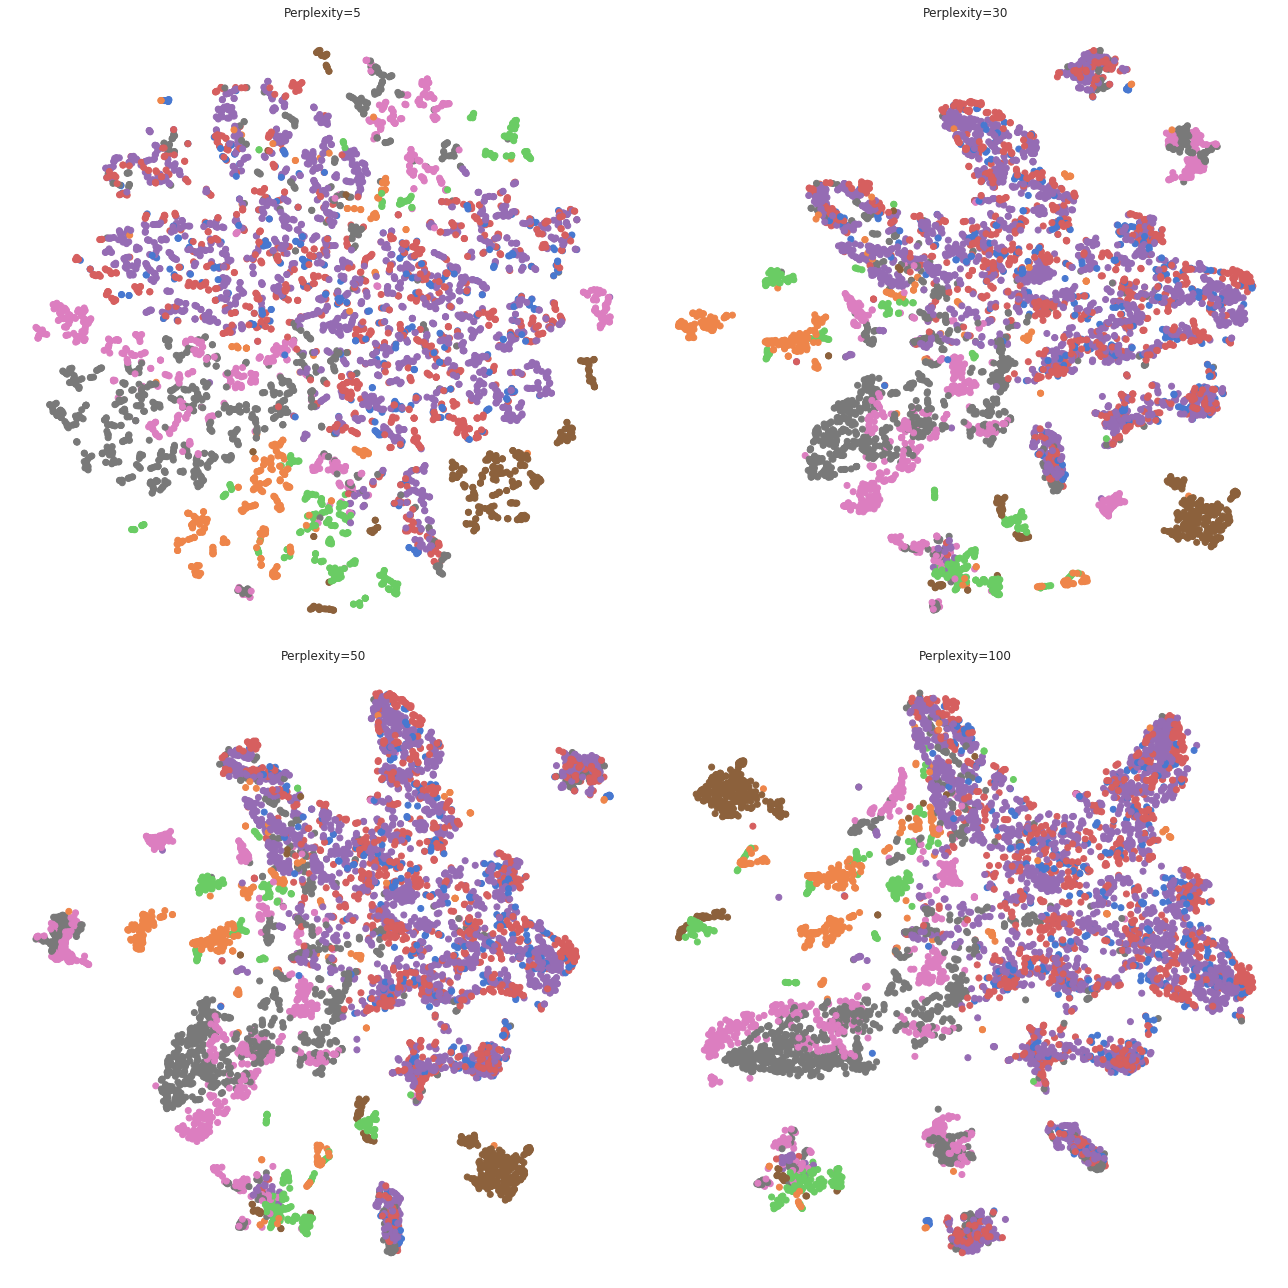

In [670]:
from sklearn.manifold import TSNE
from time import time

# targets = pd.read_csv(Path(grabo_root, "../encoded_target.csv"), index_col="uttid")
# with h5py.File(Path(grabo_root, "../features.h5"), "r") as h5f:
#     keys = [key for key in targets.index if key in h5f]
#     features = np.array([h5f[key][()][0] for key in keys])
#     targets = targets.loc[keys].copy()

# targets.columns = pd.MultiIndex.from_tuples(map(lambda s: s.split("_", maxsplit=1), targets.columns))
palette = sns.color_palette("muted", 8)
colors = targets.xs("action", axis=1, level=0).apply(lambda row: palette[np.argmax(row)], axis=1)

n_components = 2
perplexities = [5, 30, 50, 100]

fig, axs = plt.subplots(2, 2, figsize=(18,18))

for i, perplexity in enumerate(perplexities):
    
    ax = axs[i//2, i%2]
    t0 = time()
    tsne = TSNE(n_components=n_components, init='random', random_state=42, perplexity=perplexity)
    Y = tsne.fit_transform(features)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=colors)
    ax.set_axis_off()
    
plt.tight_layout()
plt.savefig("exp/figures/tsne_grabo.png")

blue approach
orange grab
green lift
red move_abs
purple move_rel
brown pointer
pink turn_abs
grey turn_rel

S-curve, perplexity=5 in 48 sec
S-curve, perplexity=30 in 54 sec
S-curve, perplexity=50 in 61 sec
S-curve, perplexity=100 in 74 sec


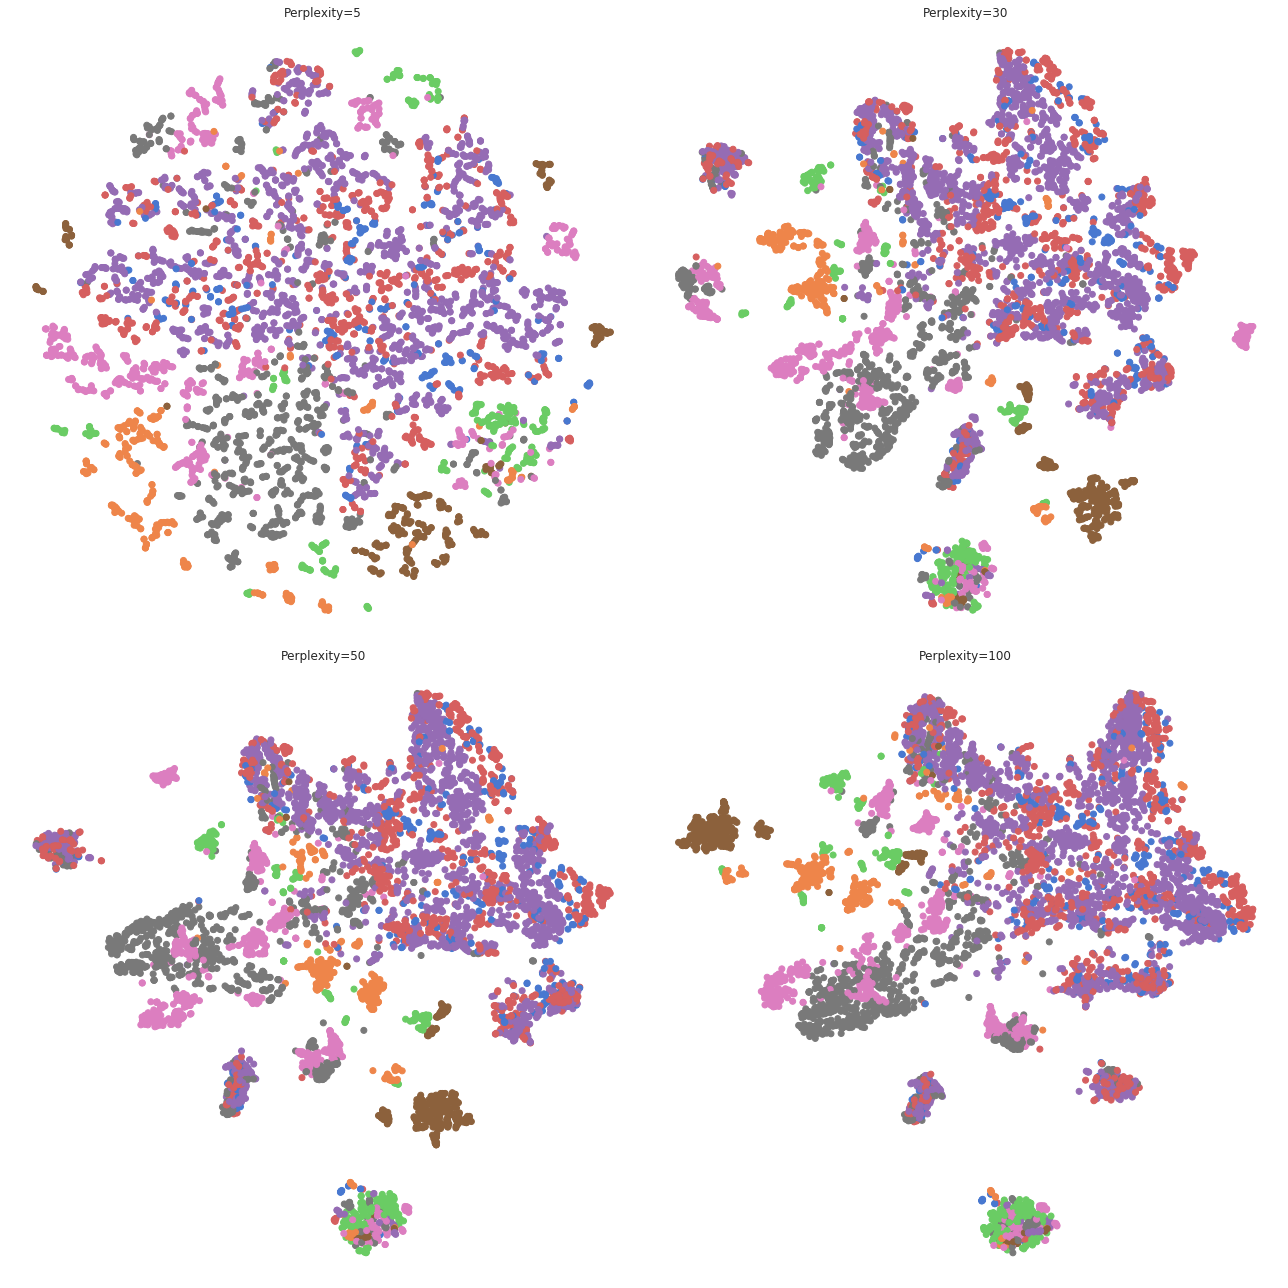

In [679]:
from sklearn.manifold import TSNE
from time import time

targets = pd.read_csv(Path(grabo_root, "../encoded_target.csv"), index_col="uttid")
with h5py.File(Path(grabo_root, "../features.h5"), "r") as h5f:
    keys = [key for key in targets.index if key in h5f]
    features = np.array([h5f[key][()].mean(0) for key in keys])
    targets = targets.loc[keys].copy()

targets.columns = pd.MultiIndex.from_tuples(map(lambda s: s.split("_", maxsplit=1), targets.columns))
palette = sns.color_palette("muted", 8)
colors = targets.xs("action", axis=1, level=0).apply(lambda row: palette[np.argmax(row)], axis=1)

n_components = 2
perplexities = [5, 30, 50, 100]

fig, axs = plt.subplots(2, 2, figsize=(18,18))

for i, perplexity in enumerate(perplexities):
    
    ax = axs[i//2, i%2]
    t0 = time()
    tsne = TSNE(n_components=n_components, init='random', random_state=42, perplexity=perplexity)
    Y = tsne.fit_transform(features)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=colors)
    ax.set_axis_off()
    
plt.tight_layout()
plt.savefig("exp/figures/tsne_grabo_mean.png")

[('action', 'approach'),
 ('action', 'grab'),
 ('action', 'lift'),
 ('action', 'move_abs'),
 ('action', 'move_rel'),
 ('action', 'pointer'),
 ('action', 'turn_abs'),
 ('action', 'turn_rel'),
 ('throttle', 'fast'),
 ('throttle', 'slow'),
 ('distance', 'alot'),
 ('distance', 'little'),
 ('distance', 'normal'),
 ('direction', 'backward'),
 ('direction', 'forward'),
 ('angle', 'east'),
 ('angle', 'north'),
 ('angle', 'south'),
 ('angle', 'west'),
 ('pos_x', 'centerx'),
 ('pos_x', 'left'),
 ('pos_x', 'right'),
 ('pos_y', 'centery'),
 ('pos_y', 'down'),
 ('pos_y', 'up'),
 ('position', 'down'),
 ('position', 'up'),
 ('state', 'off'),
 ('state', 'on'),
 ('grabber', 'close'),
 ('grabber', 'open')]

S-curve, perplexity=100 in 68 sec


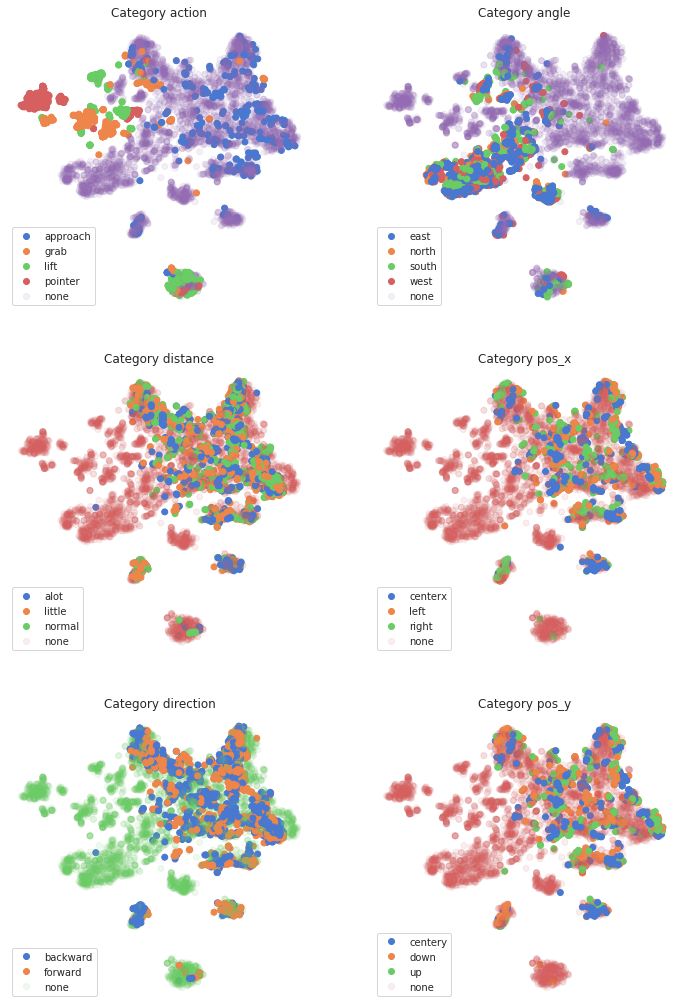

In [164]:
import h5py
from sklearn.manifold import TSNE
from time import time

targets = pd.read_csv(Path(grabo_root, "../encoded_target.csv"), index_col="uttid")
targets.columns = pd.MultiIndex.from_tuples([('action', 'approach'), ('action', 'grab'), ('action', 'lift'), ('action', 'move_abs'), ('action', 'move_rel'), ('action', 'pointer'), ('action', 'turn_abs'), ('action', 'turn_rel'), ('throttle', 'fast'), ('throttle', 'slow'), ('distance', 'alot'), ('distance', 'little'), ('distance', 'normal'), ('direction', 'backward'), ('direction', 'forward'), ('angle', 'east'), ('angle', 'north'), ('angle', 'south'), ('angle', 'west'), ('pos_x', 'centerx'), ('pos_x', 'left'), ('pos_x', 'right'), ('pos_y', 'centery'), ('pos_y', 'down'), ('pos_y', 'up'), ('position', 'down'), ('position', 'up'), ('state', 'off'), ('state', 'on'), ('grabber', 'close'), ('grabber', 'open')])
with h5py.File(Path(grabo_root, "../features.h5"), "r") as h5f:
    keys = [key for key in targets.index if key in h5f]
    features = np.array([h5f[key][()].mean(0) for key in keys])
    targets = targets.loc[keys].copy()

n_components = 2
perplexity = 100
t0 = time()
tsne = TSNE(n_components=n_components, init='random', random_state=42, perplexity=perplexity)
Y = tsne.fit_transform(features)
t1 = time()
print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

categories = ["action", "distance", "direction", "angle", "pos_x", "pos_y"]
fig, axs = plt.subplots(3, 2, figsize=(12,18))
for i, category in enumerate(categories):
    ax = axs[i%3, i//3]
    view = targets.xs(category, axis=1).assign(none=lambda df: (df.sum(axis=1) == 0).astype(int))
    palette = [c + ((1,) if i < view.shape[1] - 1 else (.1,)) for i, c in enumerate(sns.color_palette("muted", view.shape[1]))]
    colors = view.apply(lambda row: palette[np.argmax(row)], axis=1)
    ax.set_title(f"Category {category}")
    ax.scatter(Y[:, 0], Y[:, 1], c=colors)
    ax.set_axis_off()
    handles = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in palette]
    ax.legend(handles, view.columns, numpoints=1)

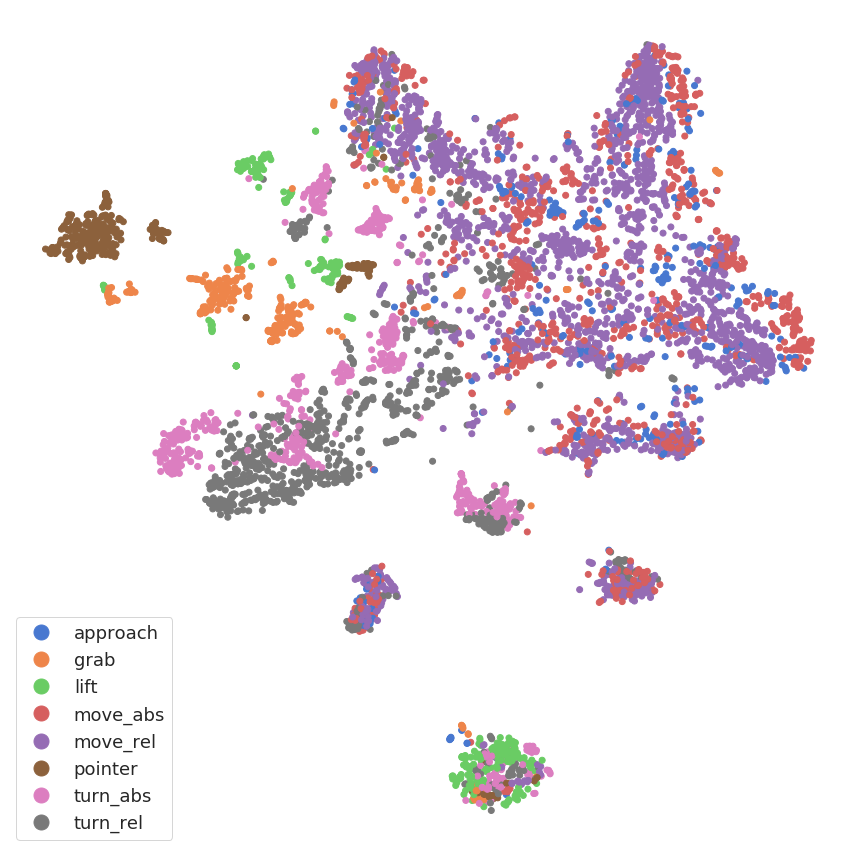

In [222]:
import h5py
from sklearn.manifold import TSNE
from time import time

# targets = pd.read_csv(Path(grabo_root, "../encoded_target.csv"), index_col="uttid")
# targets.columns = pd.MultiIndex.from_tuples([('action', 'approach'), ('action', 'grab'), ('action', 'lift'), ('action', 'move_abs'), ('action', 'move_rel'), ('action', 'pointer'), ('action', 'turn_abs'), ('action', 'turn_rel'), ('throttle', 'fast'), ('throttle', 'slow'), ('distance', 'alot'), ('distance', 'little'), ('distance', 'normal'), ('direction', 'backward'), ('direction', 'forward'), ('angle', 'east'), ('angle', 'north'), ('angle', 'south'), ('angle', 'west'), ('pos_x', 'centerx'), ('pos_x', 'left'), ('pos_x', 'right'), ('pos_y', 'centery'), ('pos_y', 'down'), ('pos_y', 'up'), ('position', 'down'), ('position', 'up'), ('state', 'off'), ('state', 'on'), ('grabber', 'close'), ('grabber', 'open')])
# with h5py.File(Path(grabo_root, "../features.h5"), "r") as h5f:
#     keys = [key for key in targets.index if key in h5f]
#     features = np.array([h5f[key][()].mean(0) for key in keys])
#     targets = targets.loc[keys].copy()

# n_components = 2
# perplexity = 100
# t0 = time()
# tsne = TSNE(n_components=n_components, init='random', random_state=42, perplexity=perplexity)
# Y = tsne.fit_transform(features)
# t1 = time()
# print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    
fig, ax = plt.subplots(1, 1, figsize=(12,12))
palette = sns.color_palette("muted", 8)
colors = targets.xs("action", axis=1, level=0).apply(lambda row: palette[np.argmax(row)], axis=1)
# ax.set_title("Perplexity=%d" % perplexity)
ax.scatter(Y[:, 0], Y[:, 1], c=colors)
ax.set_axis_off()
handles = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='', markersize=15) for color in palette]
ax.legend(handles, targets.xs("action", axis=1).columns, numpoints=1, loc=3, prop={'size': 18})
plt.tight_layout()
# plt.savefig("exp/figures/tsne_grabo_mean.png")

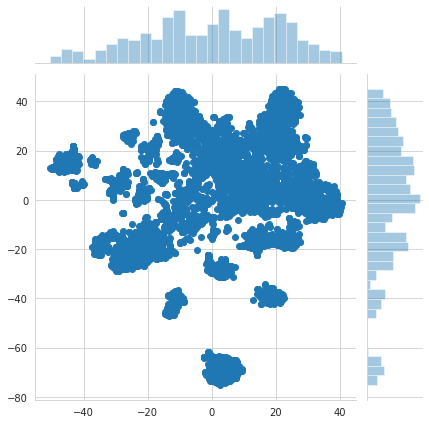

In [196]:
sns.jointplot(Y[:, 0], Y[:, 1])

In [203]:
with open("../data/grabo/text") as f:
    grabo_texts = pd.DataFrame(
        map(lambda s: s.split(" ", maxsplit=1), map(str.strip, f.readlines()))
        , columns=["uttid", "text"]
    ).set_index("uttid")
    
grabo_texts.loc[keys].loc[mask]

text
uttid                                                 
pp5_recording27_Voice_2                      turn west
pp5_recording27_Voice_1                      turn west
pp5_recording25_Voice_6                     turn north
pp5_recording31_Voice_2    quickly drive to the object
pp5_recording31_Voice_10   quickly drive to the object
...                                                ...
pp12_recording30_Voice_7                      zet neer
pp12_recording30_Voice_9                      zet neer
pp12_recording30_Voice                        zet neer
pp12_recording26_Voice_10        draai naar het zuiden
pp12_recording26_Voice_6         draai naar het zuiden

[336 rows x 1 columns]

pp7     570
pp6     559
pp11    541
pp4     540
pp2     540
pp12    540
pp9     540
pp10    540
pp8     540
pp5     540
pp3     540
Name: uttid, dtype: int64

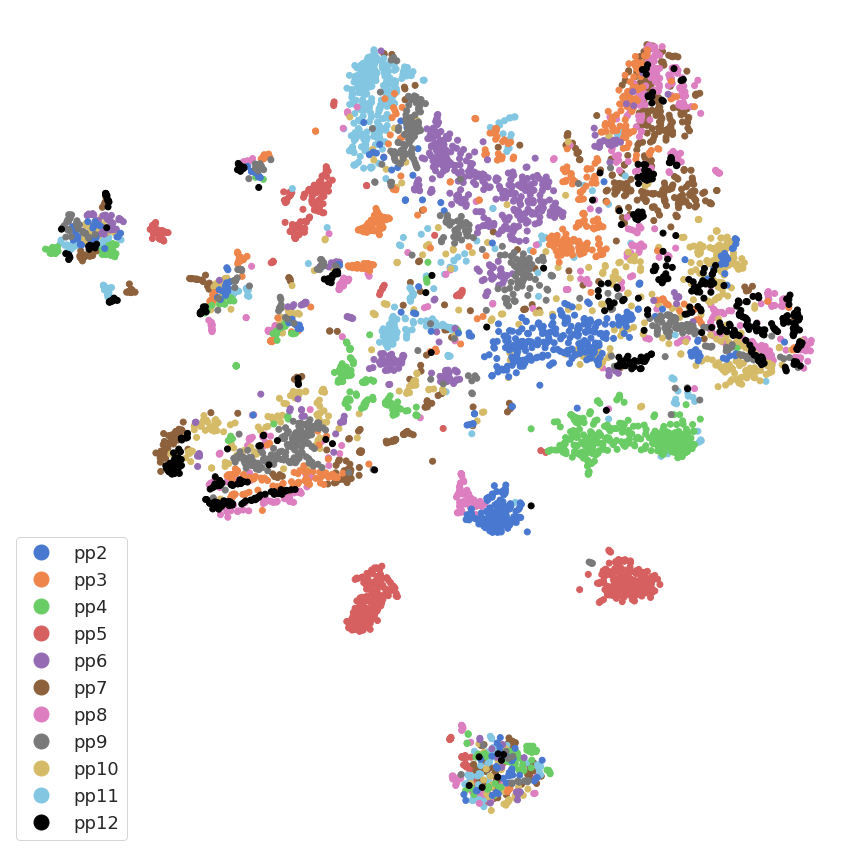

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
speakers = targets.index.map(lambda s: int(s.split("_")[0].replace("pp", "")))
palette = sns.color_palette("muted", len(speakers.unique()))
palette[-1] = (0,0,0)
color_mapping = {spkr: col for col, spkr in zip(palette, sorted(speakers.unique()))}
ax.scatter(Y[:, 0], Y[:, 1], c=speakers.map(color_mapping))
ax.set_axis_off()
handles = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='', markersize=15) for color in color_mapping.values()]
ax.legend(handles, map("pp{}".format, color_mapping.keys()), numpoints=1, loc=3, prop={'size': 18})
plt.tight_layout()

In [62]:
with open(grabo_root/'../../grabo/text') as f:
    grabo_text = (
        pd.DataFrame(
            map(lambda s: s.split(maxsplit=1), map(str.strip, f.readlines())), 
            columns=["uttid", "text"]
        )
    )

grabo_text = (
    grabo_text.join(
        grabo_text.uttid.str.extract(
            r"^(?P<speaker>pp\d+)_recording(?P<recording>\d+)_Voice_?(?P<voice>\d+)?$"
        ).fillna(0).assign(
            recording=lambda df: pd.to_numeric(df["recording"]),
            voice=lambda df: pd.to_numeric(df["voice"])
        )
    ).set_index(["speaker", "recording", "voice"])
    .drop("uttid", axis=1)
    .sort_index()
)

grabo_text.loc[["pp1", "pp2", "pp3", "pp4"]].drop_duplicates(subset=["text"]).droplevel(-1).unstack(level=0)

text  \
speaker                                             pp2   
recording                                                 
1                         rij snel een beetje naar voor   
2                         rij snel een eindje naar voor   
3                               rij snel veel naar voor   
4                        rij traag een beetje naar voor   
5                        rij traag een eindje naar voor   
6                              rij traag veel naar voor   
7                       rij snel een beetje naar achter   
8                       rij snel een eindje naar achter   
9                             rij snel veel naar achter   
10                     rij traag een beetje naar achter   
11                     rij traag een eindje naar achter   
12                           rij traag veel naar achter   
13                             rij snel naar het midden   
14                    rij snel naar de linker bovenhoek   
15                   rij snel naar de rechter onderhoek   
16                            rij traag naar het midden   
17          rij traag naar de bovenste linker bovenhoek   
18         rij traag naar de onderste rechter onderhoek   
19                                        keer traag om   
20                     keer traag een kwart naar rechts   
21                      keer traag een kwart naar links   
22                                       keer snel rond   
23                      keer snel een kwart naar rechts   
24                       keer snel een kwart naar links   
25                                keer naar het noorden   
26                                 keer naar het zuiden   
27                                 keer naar het westen   
28                                 keer naar het oosten   
29                                               hef op   
30                                             zet neer   
31                             rij snel naar het object   
32                            rij traag naar het object   
33                                  laat het object los   
34                                     grijp het object   
35                                          pointer uit   
36                                          pointer aan   

                                              \
speaker                                  pp3   
recording                                      
1                rij snel een beetje vooruit   
2                  rij snel een stuk vooruit   
3                       rij snel ver vooruit   
4               rij traag een beetje vooruit   
5                 rij traag een stuk vooruit   
6                      rij traag ver vooruit   
7              rij snel een beetje achteruit   
8                rij snel een stuk achteruit   
9                     rij snel ver achteruit   
10            rij traag een beetje achteruit   
11              rij traag een stuk achteruit   
12                   rij traag ver achteruit   
13                 rij snel naar het centrum   
14                                       NaN   
15                                       NaN   
16                rij traag naar het centrum   
17                                       NaN   
18                                       NaN   
19                            draai traag om   
20         draai traag een kwart naar rechts   
21          draai traag een kwart naar links   
22                             draai snel om   
23          draai snel een kwart naar rechts   
24           draai snel een kwart naar links   
25                       ga naar het noorden   
26                        ga naar het zuiden   
27                        ga naar het westen   
28                        ga naar het oosten   
29                                hef omhoog   
30                               laat zakken   
31                                       NaN   
32                                       NaN   
33                                       NaN   
34                   

In [6]:
import sys; sys.path.append("..")
from train_svm import load_data

X, y, indices, classes = load_data(
    features=grabo_root/'../../grabo/text', 
    targets=grabo_root/"../encoded_target.csv", 
    combine="average"
)

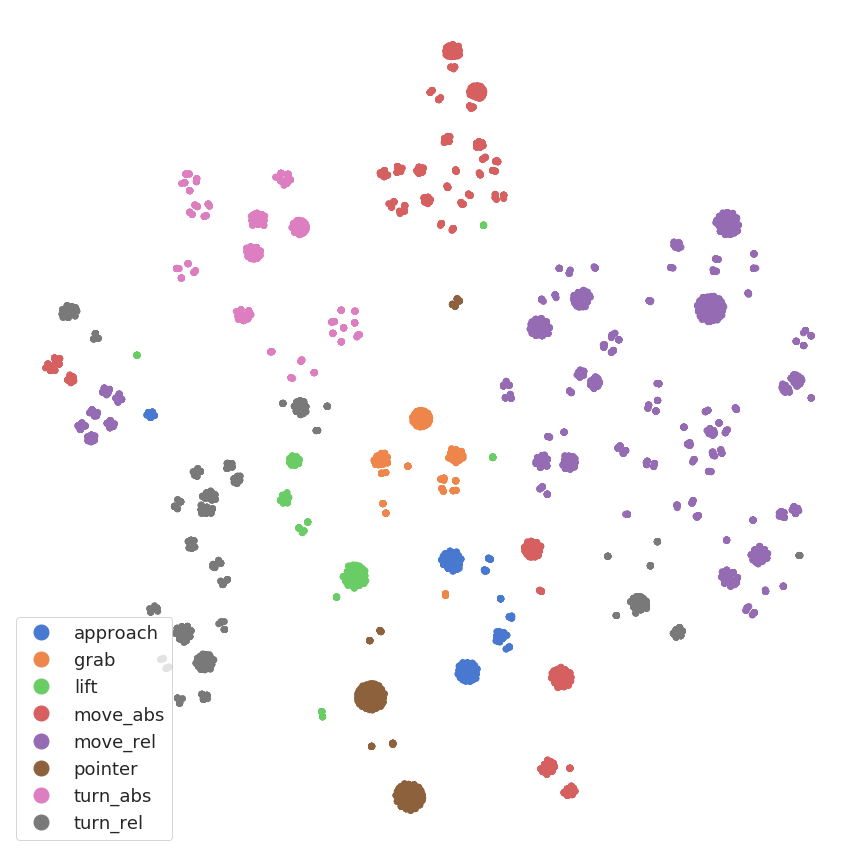

In [14]:
import h5py
from sklearn.manifold import TSNE
from time import time

columns = pd.MultiIndex.from_tuples(map(lambda s: s.split("_", maxsplit=1), classes))
targets = pd.DataFrame(y, index=indices, columns=columns)

# n_components = 2
# perplexity = 100
# t0 = time()
# tsne = TSNE(n_components=n_components, init='random', random_state=42, perplexity=perplexity)
# Y = tsne.fit_transform(X)
# t1 = time()
# print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

fig, ax = plt.subplots(1, 1, figsize=(12,12))
palette = sns.color_palette("muted", 8)
colors = targets.xs("action", axis=1).apply(lambda row: palette[np.argmax(row)], axis=1)
ax.scatter(Y[:, 0], Y[:, 1], c=colors)
ax.set_axis_off()
handles = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='', markersize=15) for color in palette]
ax.legend(handles, targets.xs("action", axis=1).columns, numpoints=1, loc=3, prop={'size': 18})
plt.tight_layout()
# plt.savefig("exp/figures/tsne_grabo_mean.png")

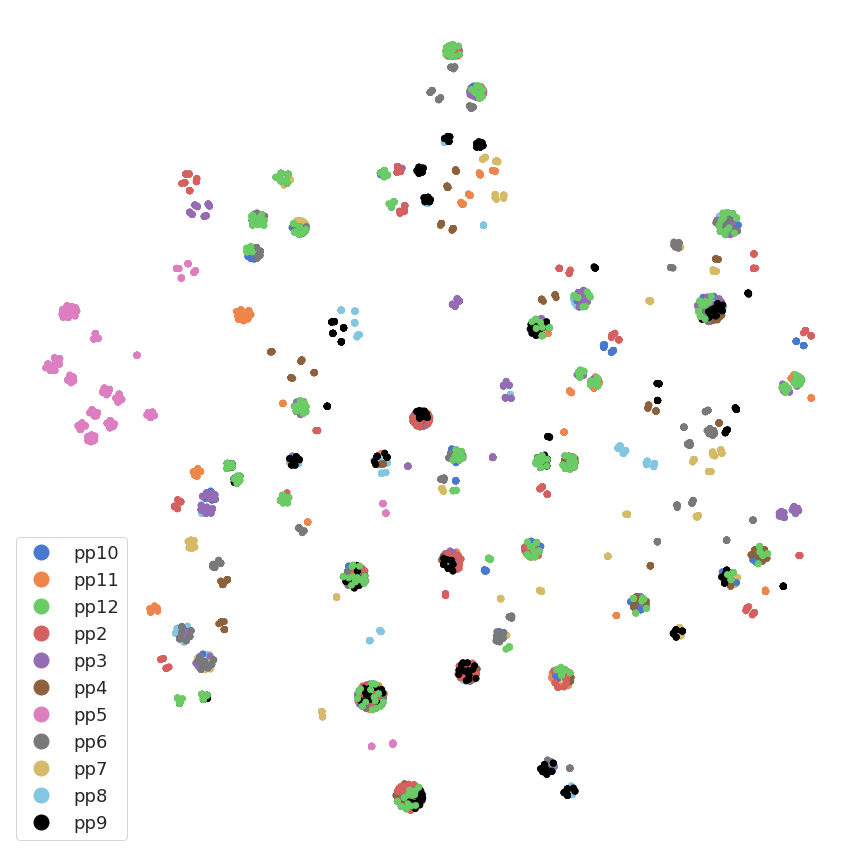

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
speakers = targets.index.str.extract("^(?P<speaker>pp\d+).*?$")["speaker"]
palette = sns.color_palette("muted", len(speakers.unique()))
palette[-1] = (0,0,0)
color_mapping = {spkr: col for col, spkr in zip(palette, sorted(speakers.unique()))}
ax.scatter(Y[:, 0], Y[:, 1], c=speakers.map(color_mapping))
ax.set_axis_off()
handles = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='', markersize=15) for color in color_mapping.values()]
ax.legend(handles, color_mapping.keys(), numpoints=1, loc=3, prop={'size': 18})
plt.tight_layout()

S-curve, perplexity=100 in 15 sec


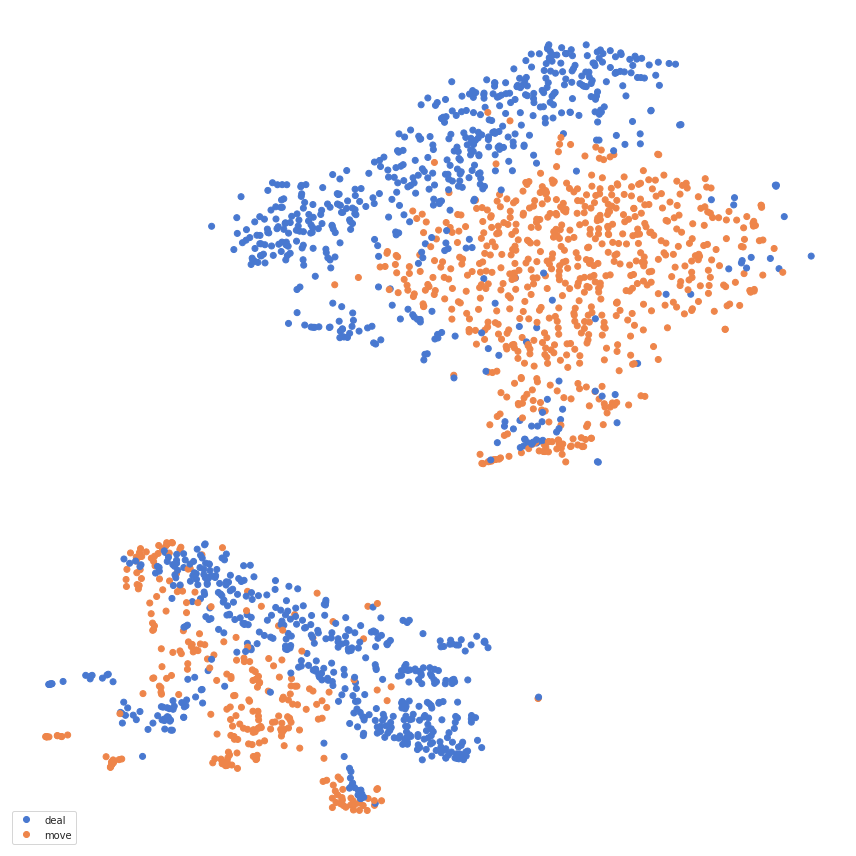

In [227]:
import h5py
from sklearn.manifold import TSNE
from time import time

targets = pd.read_csv(Path(patience_root, "../encoded_target.csv"), index_col="uttid").astype(int)
with h5py.File(Path(patience_root, "../features.h5"), "r") as h5f:
    keys = [key for key in targets.index if key in h5f]
    features = np.array([h5f[key][()].mean(0) for key in keys])
    targets = targets.loc[keys].copy()

t0 = time()
tsne = TSNE(n_components=n_components, init='random', random_state=42, perplexity=perplexity)
Y = tsne.fit_transform(features)
t1 = time()
print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    
fig, ax = plt.subplots(1, 1, figsize=(12,12))
palette = sns.color_palette("muted", 2)
colors = targets.iloc[:, :2].apply(lambda row: palette[np.argmax(row)], axis=1)
# ax.set_title("Perplexity=%d" % perplexity)
ax.scatter(Y[:, 0], Y[:, 1], c=colors)
ax.set_axis_off()
handles = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in palette]
ax.legend(handles, ["deal", "move"], numpoints=1, loc=3)
plt.tight_layout()
# plt.savefig("exp/figures/tsne_grabo_mean.png")

In [250]:
with open(patience_root / "../text") as f:
    patience_texts = pd.DataFrame(
        map(lambda s: s.split(" ", maxsplit=1), map(str.strip, f.readlines()))
        , columns=["uttid", "text"]
    ).set_index("uttid")
    
patience_texts[(targets.iloc[:, 1] == 1) & (targets.iloc[:,3] == 1)]

/esat/spchdisk/scratch/qmeeus/bin/anaconda3/envs/espnet/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


text
uttid                                                                      
pp1_move_10_110909134307                          de klaveren twee afleggen
pp1_move_12_110802152500                                    de aas afleggen
pp1_move_13_110802152510                                   de twee afleggen
pp1_move_14_110802151031                               de rode aas afleggen
pp1_move_5_110802144932     de ruiten aas op een leeg vakje bovenaan leggen
pp1_move_5_110909132551                                     de aas afleggen
pp1_move_8_110909134247                                     de aas afleggen
pp3_move_10_111012162924                              harten aas naar boven
pp3_move_11_111012162030                           schuppen twee naar boven
pp3_move_13_110913154742                      uh klaveren koning naar boven
pp3_move_25_111012162247                           schuppen drie naar boven
pp3_move_27_111012162319                           schuppen vier naar boven
pp3_move_28_110913155101                            klaveren aas naar boven
pp3_move_2_110913160126                               ruiten aas naar boven
pp3_move_30_111012163308                             harten twee naar boven
pp3_move_52_111012163731                             harten drie naar boven
pp3_move_56_111012163822                             harten vier naar boven
pp3_move_59_110913161251                             ruiten twee naar boven
pp3_move_60_110913161303                             ruiten drie naar boven
pp3_move_7_111012161947                             schuppen aas naar boven
pp4_move_13_111020151123                               rooie één naar boven
pp4_move_14_110915150813                         de één naar boven plaatsen
pp4_move_14_111020150054                      schoppen twee op vrije plaats
pp4_move_44_110915152337                                  de één naar boven
pp4_move_45_110915152347                          de zwarte twee naar boven
pp4_move_45_111020150538                              zwarte één naar boven
pp4_move_8_110915153214                                      één naar boven
pp6_move_17_111012142159                        en de aas afleggen bovenaan
pp6_move_39_111114145852                           uh aas afleggen bovenaan
pp6_move_43_111012142635                 uhm koeken twee afleggen op de aas
pp6_move_44_111012142644  koeken drie afleggen op de aas uh op de koeken...
pp6_move_50_111012142750          uh koeken vijf op de koeken vier afleggen
pp6_move_63_111114151353                     ah de aas afleggen uh bovenaan
pp6_move_6_111012143124                               aas afleggen bovenaan
pp7_move_19_111114153528                             harten twee naar boven
pp7_move_25_111020143054                           schoppen twee naar boven
pp7_move_28_111114153645                              ruiten aas naar boven
pp7_move_29_111114153654                             ruiten twee naar boven
pp7_move_40_111020142037                            schoppen aas naar boven
pp7_move_41_111020142047                           schoppen twee naar boven
pp7_move_4_111020142726                             schoppen aas naar boven
pp7_move_8_111114154747                             klaveren aas naar boven
pp8_move_13_111219175546                  de rooie haas naar het groene vak
pp8_move_14_111107181209                 de zwarte aas naar het groene vlak
pp8_move_14_111219174240   uhm de zwarte haas naar het groene vak van boven
pp8_move_55_111107181938           de zwarte twee naar de zwarte haas boven
pp8_move_56_111107181950       de zwarte drie naar de zwarte twee van boven
pp8_move_57_111107182000       de zwarte vier naar de zwarte drie van boven
pp8_move_69_111107182226          de zwarte zes naar de zwarte boven tweede
pp8_move_9_111107180111                   de zwarte haas naar de groene vak
pp9_move_11_111219142201                             klaveren aas van boven
pp9_move_15_111219141041                   

In [247]:
targets.loc[~(targets.iloc[:, 0] == 1), np.arange(2,31)]

2   3   4   5   6   7   8   9   10  11  ...  21  22  \
uttid                                                             ...           
pp1_move_10_110802152436   0   0   0   0   0   0   0   0   0   0  ...   1   0   
pp1_move_10_110909133600   0   0   0   0   0   0   0   0   0   0  ...   0   0   
pp1_move_10_110909134307   0   1   0   0   0   0   0   0   0   0  ...   0   0   
pp1_move_11_110802150957   1   0   0   0   0   0   0   0   0   0  ...   0   0   
pp1_move_11_110909132659   0   0   0   0   0   0   0   0   0   0  ...   0   1   
...                       ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..   
pp9_move_8_111110161658    0   0   0   0   0   0   0   0   0   0  ...   0   0   
pp9_move_8_111110163349    0   1   0   0   0   0   0   0   0   0  ...   0   0   
pp9_move_8_111219143739    0   1   0   0   0   0   0   0   0   0  ...   0   0   
pp9_move_9_111110163407    0   0   1   0   0   0   0   0   0   0  ...   0   0   
pp9_move_9_111219143748    0   0   0   0   0   0   0   0   0   0  ...   0   0   

                          23  24  25  26  27  28  29  30  
uttid                                                     
pp1_move_10_110802152436   0   0   0   0   1   0   1   0  
pp1_move_10_110909133600   0   0   0   0   1   0   1   0  
pp1_move_10_110909134307   0   0   0   0   0   0   1   0  
pp1_move_11_110802150957   0   0   0   0   0   0   0   1  
pp1_move_11_110909132659   1   0   0   0   0   1   0   0  
...                       ..  ..  ..  ..  ..  ..  ..  ..  
pp9_move_8_111110161658    0   1   1   0   1   0   1   0  
pp9_move_8_111110163349    0   0   0   0   0   0   1   0  
pp9_move_8_111219143739    0   0   0   0   0   0   0   1  
pp9_move_9_111110163407    0   0   0   0   1   0   0   0  
pp9_move_9_111219143748    0   1   1   0   1   0   0   1  

[947 rows x 29 columns]

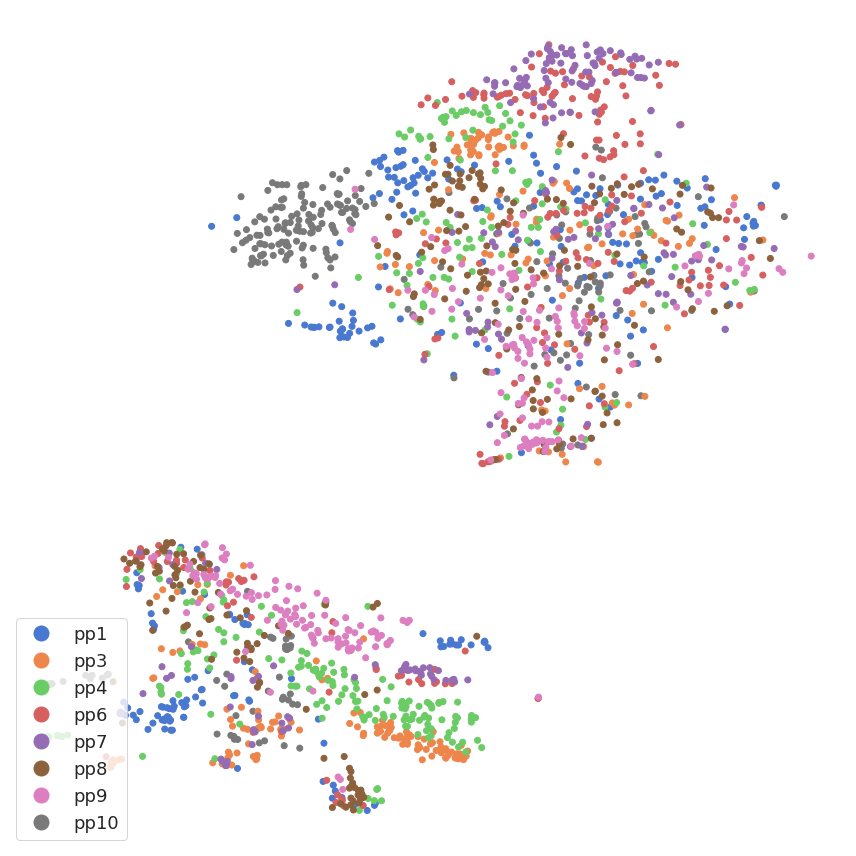

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
speakers = targets.index.map(lambda s: int(s.split("_")[0].replace("pp", "")))
palette = sns.color_palette("muted", len(speakers.unique()))
color_mapping = {spkr: col for col, spkr in zip(palette, sorted(speakers.unique()))}
ax.scatter(Y[:, 0], Y[:, 1], c=speakers.map(color_mapping))
ax.set_axis_off()
handles = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='', markersize=15) for color in color_mapping.values()]
ax.legend(handles, map("pp{}".format, color_mapping.keys()), numpoints=1, loc=3, prop={'size': 18})
plt.tight_layout()

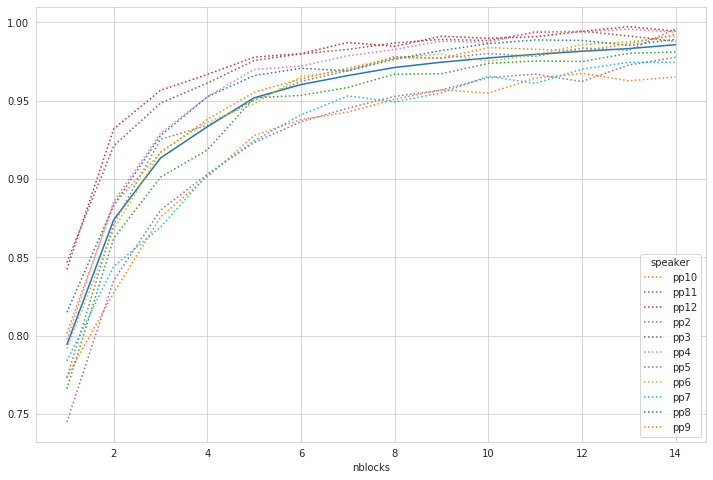

In [731]:
def parse(line):
    index, rest = line.split(":")
    spkr, exp = index.split("/")[-2:]
    nblocks, exp_id = exp.split("_")
    nblocks = int(nblocks.replace("blocks", ""))
    exp_id = int(exp_id.replace("exp", ""))
    test_acc = float(rest.split("=")[-1].replace("%", "")) / 100
    return spkr, nblocks, exp_id, test_acc

with open("exp/condor_log/results.238.txt") as f:
    test_scores = pd.DataFrame.from_records(map(parse, map(str.strip, f.readlines())))
    test_scores.columns = ["speaker", "nblocks", "exp_id", "test_acc"]
#     test_scores = test_scores.set_index(test_scores.columns[:3])
    
ax = test_scores.groupby(["nblocks"]).mean()["test_acc"].plot()
test_scores.groupby(["speaker", "nblocks"]).mean()["test_acc"].unstack(0).plot(linestyle=":", ax=ax)
plt.savefig("exp/figures/grabo_balanced_acc_mean.png")

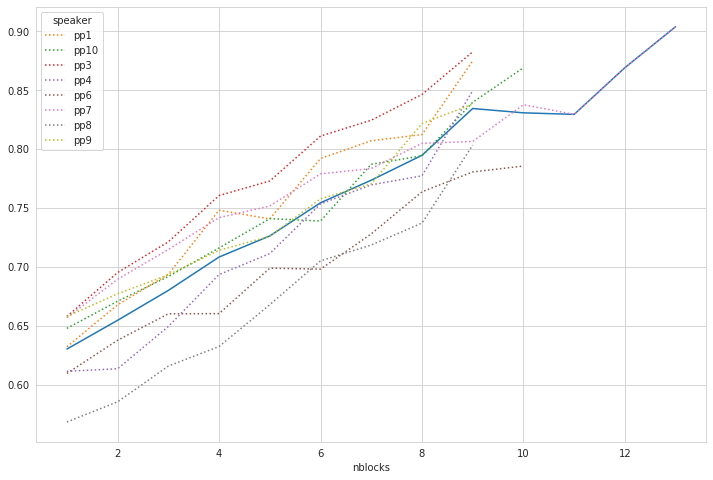

In [729]:
with open("../../patience/sti1/exp/condor_log/results.239.txt") as f:
    test_scores = pd.DataFrame.from_records(map(parse, map(str.strip, f.readlines())))
    test_scores.columns = ["speaker", "nblocks", "exp_id", "test_acc"]
#     test_scores = test_scores.set_index(test_scores.columns[:3])
    
ax = test_scores.groupby(["nblocks"]).mean()["test_acc"].plot()
test_scores.groupby(["speaker", "nblocks"]).mean()["test_acc"].unstack(0).plot(linestyle=":", ax=ax)
plt.savefig("exp/figures/patience_balanced_acc_mean.png")

In [710]:
results = load_results(patience_root)
results

precision  recall  f1-score  support
speaker nblocks exp_id class                                      
pp8     5       4      0           0.92    1.00      0.96       55
                       1           1.00    0.92      0.96       62
                       2           0.50    0.17      0.25        6
                       3           0.00    0.00      0.00        6
                       4           0.00    0.00      0.00        1
...                                 ...     ...       ...      ...
pp7     3       2      26          0.00    0.00      0.00       12
                       27          0.87    0.85      0.86       40
                       28          0.62    0.65      0.63       31
                       29          0.86    0.81      0.83       37
                       30          0.76    0.76      0.76       34

[12090 rows x 4 columns]

In [721]:
next(iter(results[["f1-score", "support"]]
 .groupby(["speaker", "nblocks", "class"]).mean()
 .groupby(["speaker", "nblocks"])
))

(('pp1', 1),
                        f1-score  support
 speaker nblocks class                   
 pp1     1       0         0.900    136.8
                 1         0.858    108.8
                 10        0.000      0.0
                 11        0.000      0.8
                 12        0.000      0.0
                 13        0.200      7.8
                 14        0.244     20.4
                 15        0.136     17.0
                 16        0.034     13.6
                 17        0.096     10.8
                 18        0.118     12.8
                 19        0.140     13.4
                 2         0.000      8.6
                 20        0.090     15.0
                 21        0.038     16.4
                 22        0.074     17.0
                 23        0.144     14.2
                 24        0.128     14.0
                 25        0.064     12.8
                 26        0.120     13.2
                 27        0.304     41.6
                 28  

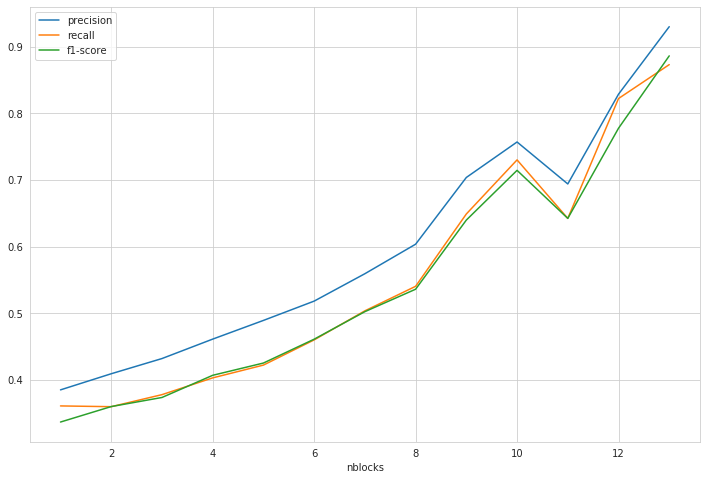

In [705]:
results = results[["precision", "recall", "f1-score"]]
results.loc[(results != 0).all(axis=1)].groupby(["speaker", "nblocks"]).mean().groupby("nblocks").mean().plot()

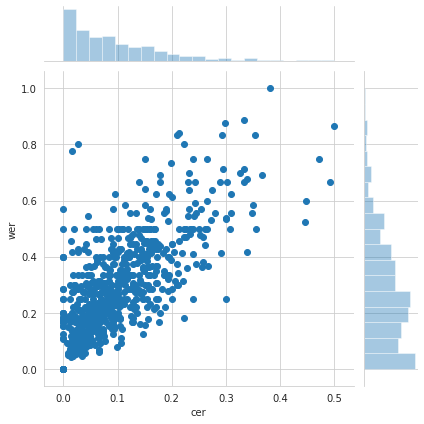

In [54]:
with open("/esat/spchdisk/scratch/qmeeus/repos/espnet/egs/cgn/asr1/exp/train_unigram_5000_mono/transformer_12_6_2048_512_8_a.4_do.1/train/evaluate/k/error_rates.json") as f:
    scores_k = json.load(f)
    
with open("/esat/spchdisk/scratch/qmeeus/repos/espnet/egs/cgn/asr1/exp/train_unigram_5000_mono/transformer_12_6_2048_512_8_a.4_do.1/train/evaluate/k/results.json") as f:
    cgn_k = json.load(f)["utts"]
    
results_k = pd.DataFrame.from_dict({
    uttid: {**scores_k[uttid], **cgn_k[uttid]["output"][0]}
    for uttid in cgn_k
}, orient="index")

sns.jointplot(x="cer", y="wer", data=results_k)